Что дальше:
1. Провести заново работу по подбору факторов с учетом макс корр.
2. В той же логике построить прогнозы для ARIMA
3. Привести к "при прочих равных" логику прогноза, т.е. НЕ переобучения модели перед каждым построением на тестовой выборке на 3 шага вперед. В VAR нужно убрать логику переобучения.
4. добавить новостностой индекс, сравнить модели

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore")

**в фичах очень много пропусков, некоторые фичи есть только по кварталам, надо подумать, как с ними работать**

**сейчас они заполняются как-то в тупую, чтобы просто модели запустить**

**нужно, чтобы макро и ипп были одной длины и с одинаковыми индексами**

In [3]:
# Я скилывал два файла. Из второго файла тоже нужно использовать факторы.
macro_1 = pd.read_excel('data/rez_file_Y_v2.xlsx', parse_dates=['date'], index_col='date')
macro_2 = pd.read_excel('data/rez_file_X_v6.xlsx', parse_dates=['date'], index_col='date')
macro = pd.concat([macro_1, macro_2], axis=1)

In [4]:
ipp = pd.read_excel('data/iip_m12_2024.xlsx')
ipp['date'] = pd.date_range(start='2005-01-31', end='2024-12-31', freq='M')
ipp.drop(columns='Unnamed: 0', inplace=True)
ipp.set_index('date', inplace=True)
# ipp = ipp.loc[min(macro.index):max(macro.index), :]

In [5]:
# Пересмотреть набор факторов с учетом двух файлов
features_dict = {
    'топливо': 
            ['Экспорт,  % накопленным итогом год к году', 
            'Инвестиции в основной капитал накопленным итогом, млрд руб', 
            'К соответствующему периоду предыдущего года'],
    
    'кокс': 
            ['Экспорт,  % накопленным итогом год к году',  
            'Импорт, млн долл. США'], 
    
    'резина': 
            ['ИПП в % к соответствующему месяцу предыдущего года',  
            'Инвестиции в основной капитал накопленным итогом, млрд руб', 
            'Инфляция, Период с начала года к соответствующему периоду предыдущего года (в среднем за год, в терминологии Минэк)'], 
    
    'химия': 
            ['ИПП в % к соответствующему месяцу предыдущего года',
            'Экспорт,  % накопленным итогом год к году',
            'Импорт, млн долл. США',
            'Инфляция, Период с начала года к соответствующему периоду предыдущего года (в среднем за год, в терминологии Минэк)']
}

In [6]:
target_dict = {
    'топливо': 'Подраздел СА Добыча топливно-энергетических полезных  ископаемых',
    
    'кокс': 'Подраздел DF Производство кокса , нефтепродуктов и ядерных материалов',
    
    'резина': 'Подраздел DH Производство резиновых и пластмассовых  изделий',
    
    'химия': 'Подраздел DG Химическое производство',    
}
inverse_d = {v: k for k, v in target_dict.items()}

# подготовка данных

In [7]:
def model_data(target: str or list, news_index=None, test_horizon=12, shift_features=0):
    ''' 
    На вход подается таргет (макро показатель) или список таргетов, 
    для него/них выбираются общие признаки, 
    по умолчанию новостной индекс не включается, его можно добавить

    На выход подается тренировочная и тестовая выборка признаков размера test_horizon для конкретного макро показателя/списка показателей

    target: str или list[str] - название таргета/список таргетов
    news_index: optional - новостной индекс
    
    Возвращает:
    macro_features: dataframe с общими признаками для всех переданных таргетов
    '''
    
    if isinstance(target, str):
        target_names = target_dict[target]
        macro_features = macro.loc[:, features_dict[target]]
        target_timerow = ipp.loc[:, target_names]
        
#     получается мы берем пересечение признаков. Должна быть еще опция объединения признаков.
    elif isinstance(target, list):
        common_features = set(features_dict[target[0]])
        for t in target[1:]:
            common_features.intersection_update(features_dict[t])

        macro_features = macro.loc[:, list(common_features)]
        
        target_names = [target_dict[t] for t in target]
        target_timerow = ipp.loc[:, target_names]
    
    
    features_names = macro_features.columns.tolist()
            


    # объединяем таргет и фичи в одинг df, сдвигаем фичи относительно таргета. Должно быть удоюно инвертировать обрабтно 
    # и строить графики. Поэтому у таргета не должна меняться временная ось.
    # shift_features = 1 - сдвигаем вперед на 1 мес. фичи, то есть значением фичи месяц назад объясняем таргет текущего месяца
    # для нейросетей shift_features = 0, так как там другая логика использования лагов
    # ! но это дает нам возможноость строить только прогнозы на 1 шаг вперед. Для многошаговых прогнозов нужно
    # отдельно фичи прогнозировать.
    concat_data = pd.concat([target_timerow, macro_features.shift(shift_features)], axis=1)
    
    # к фичам добавили новостной индекс. Он без лага относительно таргета по умолчанию!
    if news_index is not None:
        concat_data = pd.concat([concat_data, news_index], axis=1)
        features_names.append(news_index.name)

    # Удалили NA в таблице. 
    concat_data.dropna(inplace=True)

    # Разделили на train и test
    train_target = concat_data[target_names].iloc[:-test_horizon]
    test_target = concat_data[target_names].iloc[-test_horizon:]
    train_features = concat_data[features_names].iloc[:-test_horizon, :]
    test_features = concat_data[features_names].iloc[-test_horizon:, :]
    
    return train_features, test_features, train_target, test_target

In [8]:
test_news_index = macro['Новостной индекс ЦБ']
test_df = model_data(['химия', 'кокс'], news_index=test_news_index)
# test_df = model_data('химия', news_index=test_news_index)

In [9]:
def prepare_features(dataset,  scaler='standard'):
    #     нам нужны отдельно скалированные и не фактические данные
    #     raw_train, raw_test, train_target, test_target = model_data(target, news_index, forecast_horizon)
    train_features, test_features, train_target, test_target = dataset
    
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    scaler_X.fit(train_features)  # Только train!
    scaler_y.fit(pd.DataFrame(train_target))

#     scaled_train = scaler.fit_transform(raw_train)
    # Это неправильно. scaler должен знать распределение только тренировочных данных
#     scaled_test = scaler.fit_transform(raw_test)

    train_features_scaled = scaler_X.transform(train_features)
    test_features_scaled = scaler_X.transform(test_features)

    if isinstance(train_target, pd.Series):
        train_target_scaled = scaler_y.transform(pd.DataFrame(train_target))
        test_target_scaled = scaler_y.transform(pd.DataFrame(test_target))
    else:
        train_target_scaled = scaler_y.transform(train_target)
        test_target_scaled = scaler_y.transform(test_target)
        
    #     возвращаем индексы и названия
    train_features_scaled = pd.DataFrame(train_features_scaled, columns=train_features.columns, index=train_features.index)
    test_features_scaled = pd.DataFrame(test_features_scaled, columns=test_features.columns, index=test_features.index)

    if isinstance(train_target, pd.Series):

        train_target_scaled = pd.DataFrame(train_target_scaled.reshape(1,-1)[0],
                                           columns=[train_target.name], index=train_target.index)
        test_target_scaled = pd.DataFrame(test_target_scaled.reshape(1,-1)[0],
                                           columns=[test_target.name], index=test_target.index)
    else:
        
        train_target_scaled = pd.DataFrame(train_target_scaled, columns=train_target.columns, index=train_target.index)
        test_target_scaled = pd.DataFrame(test_target_scaled, columns=test_target.columns, index=test_target.index)
        
    
    
    set_data = train_features_scaled, test_features_scaled, train_target_scaled, test_target_scaled
    return scaler_y, set_data


In [10]:
my_scaler, set_data = prepare_features(test_df)

<!-- - если для модели нужны данные в абсолюных величинах, используется **model_data()**

- если нужны нормализованные данные, то используется **prepare_features()**

обе функции на выходе дают тренировочные и тестовые выборки признаков и таргета/таргетов -->

# VAR

Нужно использовать varx и прогнозировать на 3 мес. вперед. Только так есть смысл с нейросетями сравнивать.
при этом на прогнозном горизонте нужно переиспользоваьт прогнозы var для таргетов и замораживать последние известные значения для фичей или отдельно их прогнозировать

## VARX

In [291]:
def select_best_lag(endog, exog, max_lag=5, criterion='aic'):
    """
    Подбирает оптимальный лаг для VARX (VARMAX) по критерию AIC или BIC.
    endog: DataFrame — таргеты
    exog: DataFrame — экзогенные переменные
    max_lag: int — максимальный перебираемый лаг
    criterion: 'aic' или 'bic'
    """
    best_score = np.inf
    best_lag = None
    scores = {}
    for lag in range(1, max_lag + 1):
        try:
            model = VARMAX(endog, exog=exog, order=(lag, 0))
            res = model.fit(disp=False)
            score = getattr(res, criterion)
            scores[lag] = score
            if score < best_score:
                best_score = score
                best_lag = lag
        except Exception as e:
            print(f"Lag {lag}: error {e}")
            continue
    return best_lag, scores

In [326]:
def rolling_varx_forecast(
    train_target, train_features, test_target, test_features, lags=2, horizon=3):
    """
    Скользящий прогноз VARX/VARMAX: rolling window с прогнозом на 3 шага вперед.
    На каждом окне экзогенные берутся как последнее доступное значение в расширенной истории.
    train_target, train_features, test_target, test_features — DataFrame!
    Возвращает:
      - forecasts: (n_windows, horizon, n_targets)
      - actuals:   (n_windows, horizon, n_targets)
      - insample_forecasts: список, каждый элемент — DataFrame in-sample прогноза на расширенном обучающем окне
      - insample_actuals: список, каждый элемент — DataFrame фактических значений на обучающем окне
    """
    forecasts = []
    actuals = []
    insample_forecasts = []
    insample_actuals = []

    n_test = test_target.shape[0]

    # Копии для чистоты
    endog = train_target.copy()
    exog = train_features.copy()
    test_endog = test_target.copy()
    test_exog = test_features.copy()

    
    for start in range(n_test - horizon + 1):
        # Расширенная история на этом окне
        hist_endog = pd.concat([endog, test_endog.iloc[:start]], axis=0, ignore_index=True)
        hist_exog = pd.concat([exog, test_exog.iloc[:start]], axis=0, ignore_index=True)

        # Экзогенные на 3 будущих шага — последнее известное
        last_exog = hist_exog.iloc[-1]
        exog_future = pd.DataFrame([last_exog.values]*horizon, columns=hist_exog.columns)

        try:
            # Переобучаем модель через каждые три шага, то есть перед каждым очередным тройным прогнозом 
            # строится новая модель на расширенной истории (train + всё, что уже известно из test до текущего окна)
            model = VARMAX(hist_endog, exog=hist_exog, order=(lags, 0))#2-й параметр в order - это MA (внезапно)
            res = model.fit(disp=False)

            # Прогноз на 3 шага вперёд
            fcst = res.forecast(steps=horizon, exog=exog_future)
            forecasts.append(fcst.values)
            actuals.append(test_endog.iloc[start:start+horizon].values)

            # In-sample прогноз (только на обучающем окне)
            insample_pred = res.fittedvalues  # shape: (len(hist_endog), n_targets)
            insample_forecasts.append(insample_pred.values)
            insample_actuals.append(hist_endog.values)
        except Exception as e:
            print(f"Ошибка на окне {start}: {e}")
            continue

    forecasts = np.array(forecasts)
    actuals = np.array(actuals)


    return forecasts, actuals, insample_forecasts, insample_actuals


In [322]:
def forecasts_to_long_df(forecasts, actuals, test_target, horizon=3):
    """
    forecasts: (n_windows, horizon, n_targets)
    actuals:   (n_windows, horizon, n_targets)
    test_target: DataFrame, shape (n_test, n_targets), индекс — даты
    
    Вернет DataFrame: columns = [iteration, forecast_date, y_hat, y_true]
    """
    n_windows, h, n_targets = forecasts.shape
    result = []

    # Получаем даты для rolling окон
    test_dates = test_target.index

    for i in range(n_windows):
        for j in range(horizon):
            for k in range(n_targets):
                # Вычисляем индекс даты
                date_idx = i + j
                if date_idx >= len(test_dates):
                    continue  # на случай выхода за тестовый диапазон
                result.append({
                    'iteration': i,
                    'forecast_date': test_dates[date_idx],
                    'target': test_target.columns[k],
                    'y_hat': forecasts[i, j, k],
                    'y_true': actuals[i, j, k]
                })

    df_long = pd.DataFrame(result)
    return df_long


In [350]:
def insample_to_long_df(insample_forecasts, insample_actuals, train_target, test_target):
    """
    insample_forecasts, insample_actuals: списки массивов (len=n_windows), shape каждого: (len_hist, n_targets)
    train_target: DataFrame (train_len, n_targets), индекс — даты
    test_target: DataFrame (n_test, n_targets), индекс — даты

    Вернет DataFrame: columns = [iteration, forecast_date, target, y_hat, y_true]
    """
    result = []
    train_dates = train_target.index
    test_dates = test_target.index
    n_windows = len(insample_forecasts)
    n_train = train_target.shape[0]
    n_targets = train_target.shape[1]

    for i in range(n_windows):
        n_hist = insample_forecasts[i].shape[0]
        # Даты для этого окна: сначала train, затем часть test
        dates = list(train_dates) + list(test_dates[:max(0, n_hist - n_train)])
        for t in range(n_hist):
            for k in range(n_targets):
                result.append({
                    'iteration': i,
                    'forecast_date': dates[t],
                    'target': train_target.columns[k],
                    'y_hat': insample_forecasts[i][t, k],
                    'y_true': insample_actuals[i][t, k]
                })
    df_long = pd.DataFrame(result)
    return df_long


In [ ]:
train_features, test_features, train_target, test_target = test_df
best_lag, scores = select_best_lag(train_target, train_features,
                                   max_lag=5, criterion='aic')

forecasts, actuals, insample_forecasts, insample_actuals = rolling_varx_forecast(train_target,
                            train_features, test_target, test_features, lags=best_lag, horizon=3)

insample = insample_to_long_df(insample_forecasts, insample_actuals, train_target, test_target)
insample['target'] = insample.target.replace(inverse_d)

outsample = forecasts_to_long_df(forecasts, actuals, test_target, horizon=3)
outsample['target'] = outsample.target.replace(inverse_d)

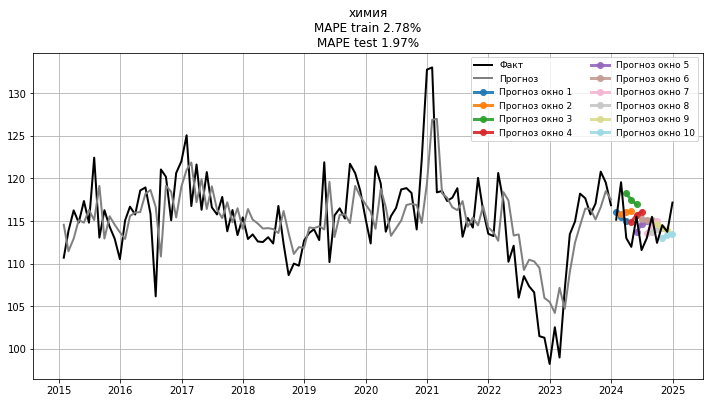

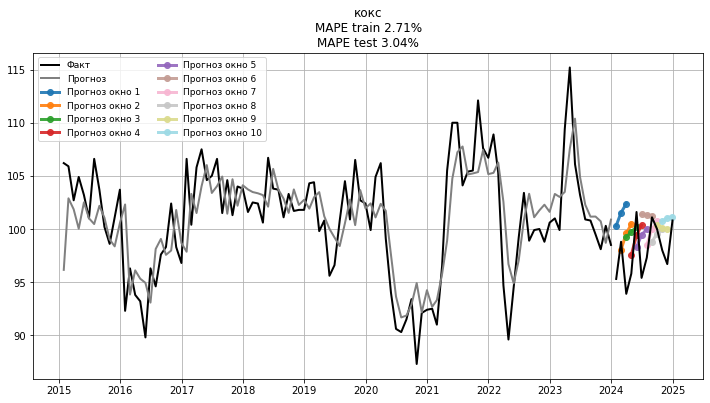

In [431]:
for check_target in insample['target'].unique():
#     check_target = 'химия'
    insample_0 = insample[(insample['target']==check_target)&(insample['iteration']==0)]
    mape_train = mean_absolute_percentage_error(insample_0.y_true, insample_0.y_hat).round(4)*100

    plt.figure(figsize=(12,6))
    plt.plot(insample_0.forecast_date, insample_0.y_true, label='Факт', color='black', linewidth=2, zorder=5)
    plt.plot(insample_0.forecast_date, insample_0.y_hat, label='Прогноз', color='grey', linewidth=2, zorder=5)
    n_iter = outsample['iteration'].nunique()
    colors = cm.get_cmap('tab20', n_iter)
    outsample_unic = outsample[outsample['target']==check_target]
    mape_test = mean_absolute_percentage_error(outsample_unic.y_true, outsample_unic.y_hat).round(4)*100
    
    fact_test = outsample_unic.drop_duplicates(subset=['forecast_date']).set_index('forecast_date')
    plt.plot(fact_test.y_true, color='black', linewidth=2, zorder=5)
    
    for iteration in range(n_iter):
        group = outsample_unic[outsample_unic['iteration']==iteration]
        plt.plot(group['forecast_date'], group['y_hat'], 
                 color=colors(iteration), marker='o', alpha=0.9, lw=3, label=f'Прогноз окно {iteration+1}')
    plt.legend(ncol=2, fontsize=9)
    plt.grid(True)
    plt.title(check_target +'\n'+ f'MAPE train {mape_train}%' +'\n'+ f'MAPE test {mape_test}%')



In [359]:
# нужно посчитать dm тест на 1 шаг, 2 шаг и 3 шаг отдельно для разных моделей.

In [294]:
def optimal_lag(target: list, max_lags=15, forecast_horizon=12):
    '''Выбор оптимального числа лагов'''

    target = [target_dict[t] for t in target]
    
    timerow = ipp.loc[:, target]
    timerow_train = timerow.iloc[:len(ipp) - forecast_horizon]
    timerow_test = timerow.iloc[-forecast_horizon:]
    # timerow = timerow.iloc[:-forecast_horizon, :]
    
    model = VAR(timerow_train)
    selected_lag = model.select_order(maxlags=max_lags).aic
    print(f"optimal lag: {selected_lag}\n")
    var_model = model.fit(selected_lag)

    # last_value = timerow.values[-var_model.k_ar:]
    # last_date = timerow.index[-1]

    # return var_model, last_value
    # return var_model, (last_date, last_value)
    return var_model, (timerow_train, timerow_test)

In [29]:
# какие факторы и лаги используются для прогнозирования
# не будет ли такого, что получится 20 объясняющих переменных для 10 лагов

In [31]:
# optimal_lag(['химия', 'кокс', 'резина'])

In [33]:
proms = ['химия', 'кокс', 'резина']
model, data = optimal_lag(proms, forecast_horizon=12)

optimal lag: 14



In [35]:
# собираю лаги для предсказания на тренировочной выборке

train_lags_values = data[0].iloc[:model.k_ar, :].values.reshape(model.k_ar, len(proms))
train_prediction = model.forecast(train_lags_values, steps=len(data[0])- model.k_ar)

columns = [f"var_{t}" for t in proms]
train_prediction = pd.DataFrame(train_prediction, columns=columns, index=data[0].index[model.k_ar:])

In [37]:
# лаги для теста 

test_lags_values = data[0].iloc[-model.k_ar:].values.reshape(model.k_ar, len(proms))
test_prediction = model.forecast(test_lags_values, steps=len(data[1]))

columns = [f"var_{t}" for t in proms]
test_prediction = pd.DataFrame(test_prediction, columns=columns, index=data[1].index)

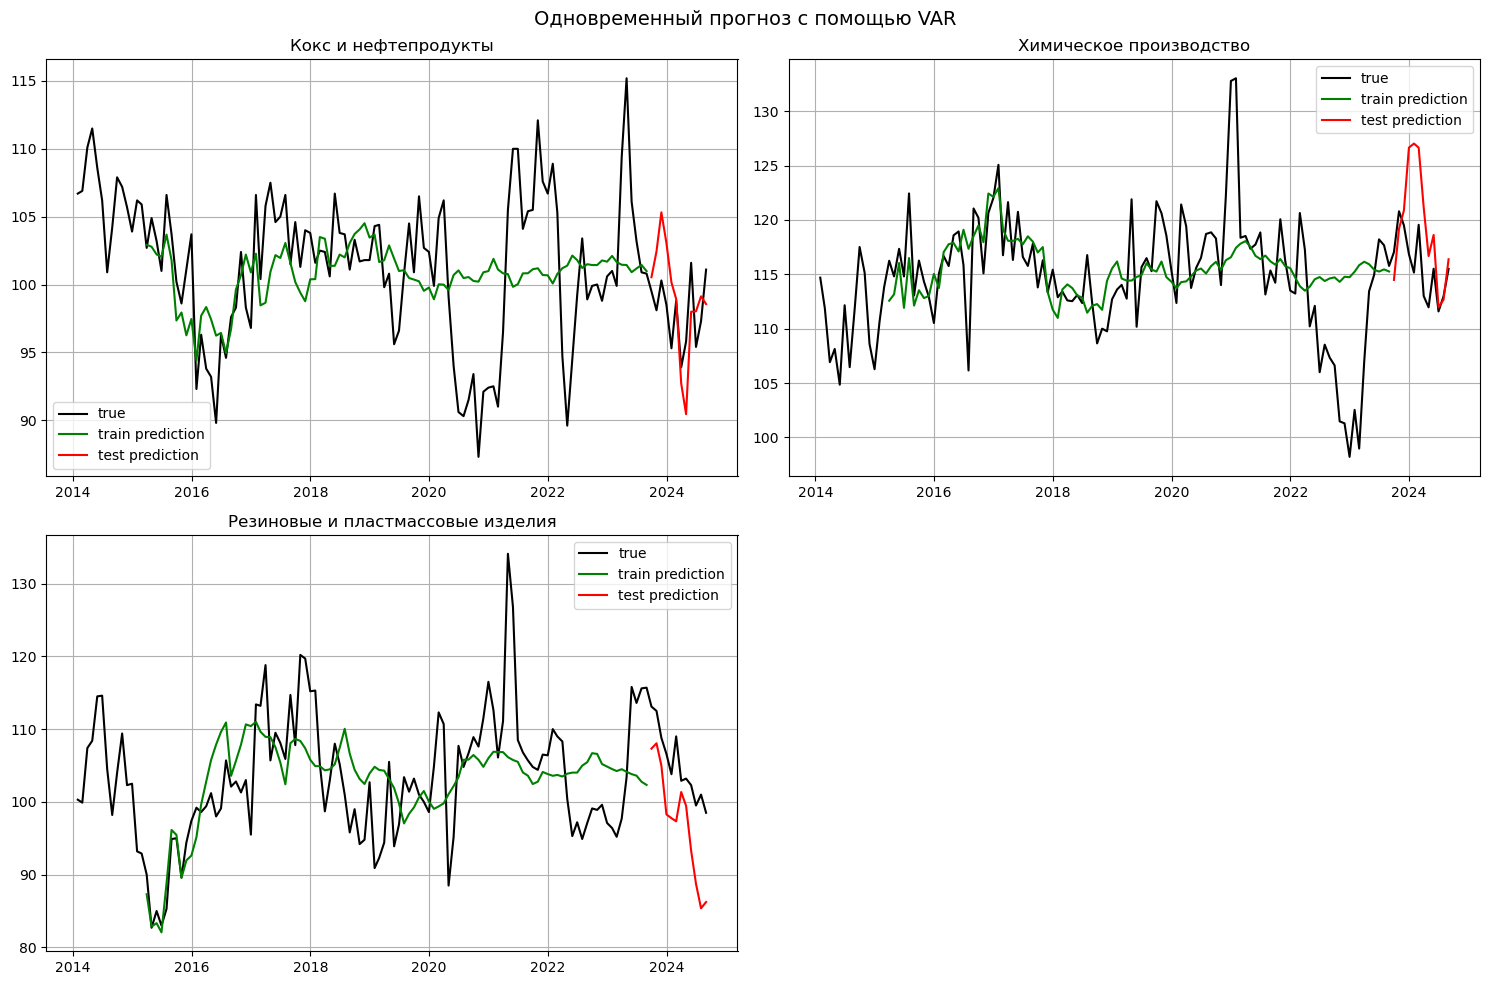

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

full = pd.concat([data[0], data[1]])

axes[0][0].plot(full.index, full['Подраздел DF Производство кокса , нефтепродуктов и ядерных материалов'], c='black', label='true')
axes[0][0].plot(train_prediction.index, train_prediction.var_кокс, c='green', label='train prediction')
axes[0][0].plot(test_prediction.index, test_prediction.var_кокс, c='red', label='test prediction')
axes[0][0].set_title('Кокс и нефтепродукты')
axes[0][0].grid()
axes[0][0].legend()

axes[1][0].plot(full.index, full['Подраздел DH Производство резиновых и пластмассовых  изделий'], c='black', label='true')
axes[1][0].plot(train_prediction.index, train_prediction.var_резина, c='green', label='train prediction')
axes[1][0].plot(test_prediction.index, test_prediction.var_резина, c='red', label='test prediction')
axes[1][0].set_title('Резиновые и пластмассовые изделия')
axes[1][0].grid()
axes[1][0].legend()

axes[0][1].plot(full.index, full['Подраздел DG Химическое производство'], c='black', label='true')
axes[0][1].plot(train_prediction.index, train_prediction.var_химия, c='green', label='train prediction')
axes[0][1].plot(test_prediction.index, test_prediction.var_химия, c='red', label='test prediction')
axes[0][1].set_title('Химическое производство')
axes[0][1].grid()
axes[0][1].legend()

fig.delaxes(axes[1][1])

fig.suptitle('Одновременный прогноз с помощью VAR', fontsize=14)
plt.tight_layout()
# plt.savefig('new/var_graphs0.png')
plt.show()

In [42]:
def var(target: list, forecast_horizon=12):    
    var_model, timerow = optimal_lag(target)

    last_values = timerow[0].iloc[:var_model.k_ar, :].values.reshape(var_model.k_ar, len(target))
    last_date = timerow[0].index[-1]
    
    # last_values = last_info[1]
    # last_date = last_info[0]
    
    prediction = var_model.forecast(last_values, steps=forecast_horizon)
        
    future_dates = pd.date_range(
            start=last_date + pd.offsets.MonthBegin(1),  # Следующий день после последней даты
            periods=forecast_horizon,
            freq='ME'
        )
    
    columns = [f"var_{t}" for t in target]
    
    prediction = pd.DataFrame(prediction, columns=columns, index=future_dates)
    return prediction

In [44]:
# var(['химия', 'кокс', 'топливо'])

# ARIMA

In [34]:
def arima_seas(ts, pdq, exogen=None):
    results = []
    
    for param in pdq:
        try:
            if exogen is not None:
                mod = ARIMA(ts, exog=exogen, order=param)
            else:
                mod = ARIMA(ts, order=param)  
                
            res = mod.fit()
            results.append((res.bic, param))
        except Exception as e:
            print(e)
            continue
  
    results.sort(key=lambda x: x[0])
    return results[0] if results else None

In [52]:
def arima(target: str, exog=False, news_index=None, forecast_horizon=12):
    
    p, d, q = range(0,4), [0,1], range(0,4)
    pdq = list(itertools.product(p, d, q))

    train_features, test_features, train_target, test_target = model_data(target, news_index, forecast_horizon)
    
    if exog == True:
#         нельзя так делать  - fillna(0)
        train_features, test_features = train_features.fillna(0), test_features.fillna(0)
        
        best_model = arima_seas(train_target, exogen=train_features,  pdq=pdq)
        
#         получается мы х в период t объясняем y в период t. Так нельзя. Должны быть лаги
        model = ARIMA(train_target, exog=train_features,  order=best_model[1])
        model_fit = model.fit()

# мы прогнозируем на тестововй выборке y t+1  с фактом x t+1. От куда мы его можем знать? Даже если сделать лаг 1, то все равно 
# проблема не решается. Нужно строить итеративный прогноз на основе предыдущего прогноза. А экзогенные дополнительно прогнозировать другой аримой.
        prediction = model_fit.forecast(steps=len(test_target), exog=test_features)
        name = 'arimax'

    else:
        best_model = arima_seas(train_target,  pdq)
        model = ARIMA(train_target,  order=best_model[1])
        model_fit = model.fit()
# здесь тоже самое
        prediction = model_fit.forecast(steps=len(test_target))
        name = 'arima'

    error = mean_squared_error(test_target, prediction) 
    print(f'mse error: {error:.3f}')
    
    prediction.name = f'{name}_{target}'

    # return pd.DataFrame(prediction)
    return model_fit, pd.DataFrame(prediction)

In [53]:
# df = arima('кокс', exog=True)

In [55]:
train_features, test_features, train_target, test_target = model_data('кокс')

In [57]:
# train_features
# train_target

date
2005-01-31    109.2
2005-02-28    100.5
2005-03-31    100.7
2005-04-30    102.3
2005-05-31    104.4
              ...  
2023-08-31    100.8
2023-09-30     99.5
2023-10-31     98.1
2023-11-30    100.3
2023-12-31     98.5
Name: Подраздел DF Производство кокса , нефтепродуктов и ядерных материалов, Length: 228, dtype: float64

In [54]:
model_arimax, cox_arimax_test = arima('кокс', exog=True)

The indices for endog and exog are not aligned
The indices for endog and exog are not aligned
The indices for endog and exog are not aligned
The indices for endog and exog are not aligned
The indices for endog and exog are not aligned
The indices for endog and exog are not aligned
The indices for endog and exog are not aligned
The indices for endog and exog are not aligned
The indices for endog and exog are not aligned
The indices for endog and exog are not aligned
The indices for endog and exog are not aligned
The indices for endog and exog are not aligned
The indices for endog and exog are not aligned
The indices for endog and exog are not aligned
The indices for endog and exog are not aligned
The indices for endog and exog are not aligned
The indices for endog and exog are not aligned
The indices for endog and exog are not aligned
The indices for endog and exog are not aligned
The indices for endog and exog are not aligned
The indices for endog and exog are not aligned
The indices f

TypeError: 'NoneType' object is not subscriptable

In [ ]:
train_features, test_features, train_target, test_target = model_data('кокс')

In [ ]:
cox_arimax_train = model_arimax.forecast(steps=len(train_target), exog=train_features.fillna(0))

In [ ]:
cox_arimax_train = pd.DataFrame(cox_arimax_train.values, index=train_features.index, columns=['arimax_кокс'])

In [53]:
model_arimax, rez_arimax_test = arima('резина', exog=True)

train_features, test_features, train_target, test_target = model_data('резина')
rez_arimax_train = model_arimax.forecast(steps=len(train_target), exog=train_features.fillna(0))
rez_arimax_train = pd.DataFrame(rez_arimax_train.values, index=train_features.index, columns=['arimax_резина'])

model_arimax, chem_arimax_test = arima('химия', exog=True)

train_features, test_features, train_target, test_target = model_data('химия')
chem_arimax_train = model_arimax.forecast(steps=len(train_target), exog=train_features.fillna(0))
chem_arimax_train = pd.DataFrame(chem_arimax_train.values, index=train_features.index, columns=['arimax_химия'])

mse error: 50.076
mse error: 3996.414
mse error: 408.161


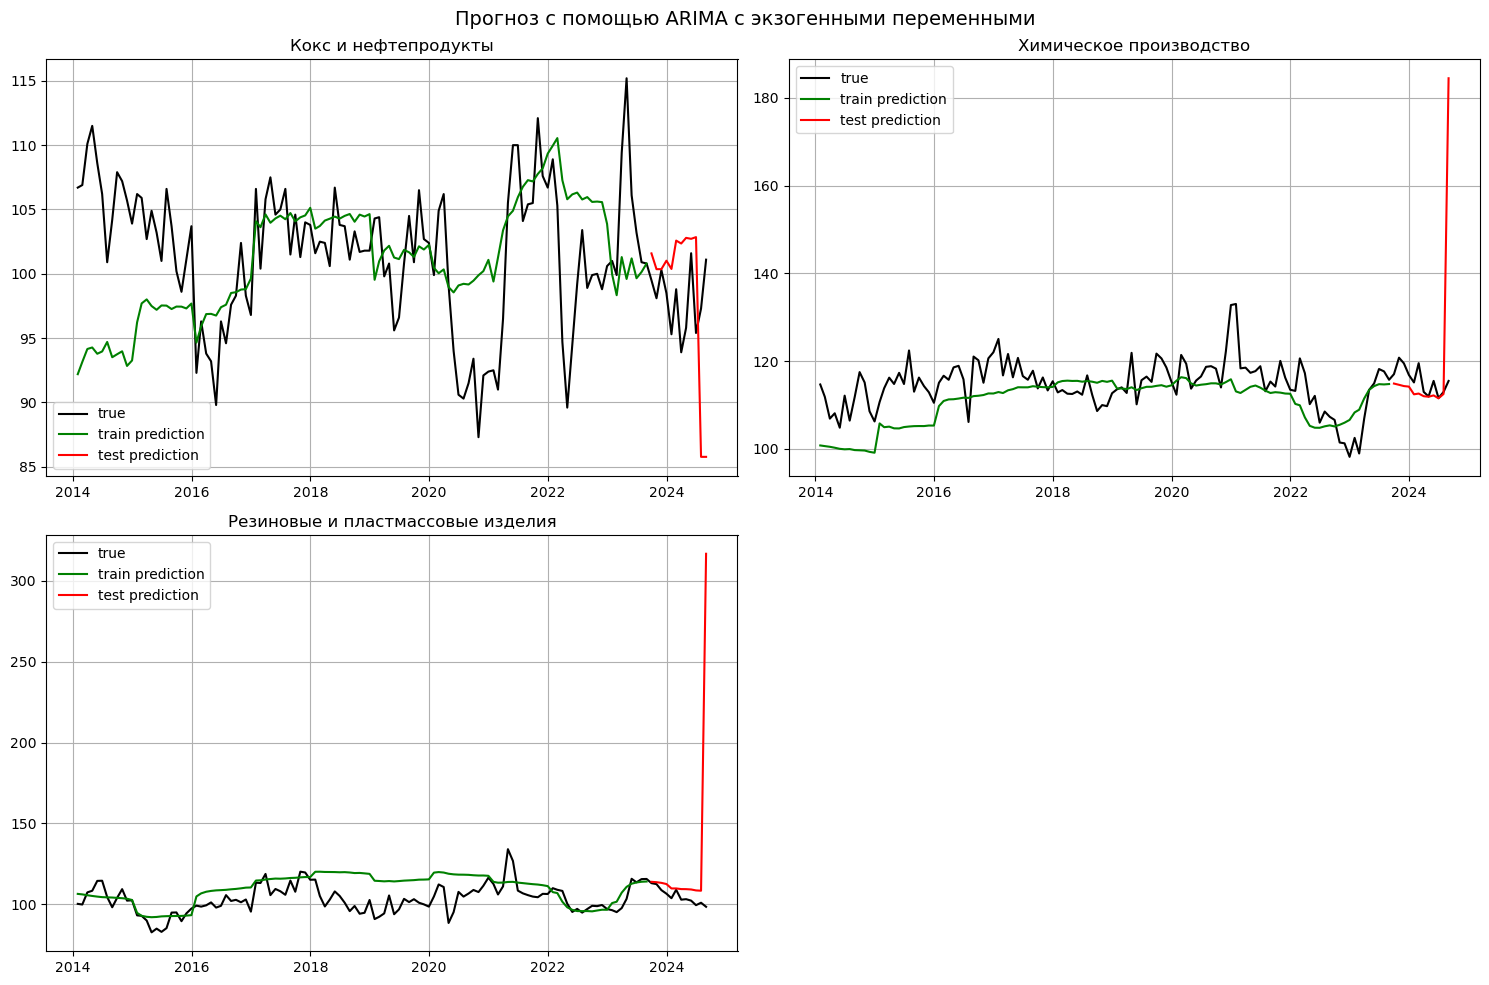

In [54]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

axes[0][0].plot(full.index, full['Подраздел DF Производство кокса , нефтепродуктов и ядерных материалов'], c='black', label='true')
axes[0][0].plot(cox_arimax_train.index, cox_arimax_train.arimax_кокс, c='green', label='train prediction')
axes[0][0].plot(cox_arimax_test.index, cox_arimax_test.arimax_кокс, c='red', label='test prediction')
axes[0][0].set_title('Кокс и нефтепродукты')
axes[0][0].grid()
axes[0][0].legend()

axes[1][0].plot(full.index, full['Подраздел DH Производство резиновых и пластмассовых  изделий'], c='black', label='true')
axes[1][0].plot(rez_arimax_train.index, rez_arimax_train.arimax_резина, c='green', label='train prediction')
axes[1][0].plot(rez_arimax_test.index, rez_arimax_test.arimax_резина, c='red', label='test prediction')
axes[1][0].set_title('Резиновые и пластмассовые изделия')
axes[1][0].grid()
axes[1][0].legend()

axes[0][1].plot(full.index, full['Подраздел DG Химическое производство'], c='black', label='true')
axes[0][1].plot(chem_arimax_train.index, chem_arimax_train.arimax_химия, c='green', label='train prediction')
axes[0][1].plot(chem_arimax_test.index, chem_arimax_test.arimax_химия, c='red', label='test prediction')
axes[0][1].set_title('Химическое производство')
axes[0][1].grid()
axes[0][1].legend()

fig.delaxes(axes[1][1])

fig.suptitle('Прогноз с помощью ARIMA с экзогенными переменными', fontsize=14)
plt.tight_layout()
# plt.savefig('new/var_graphs0.png')
plt.show()

In [57]:
model_arima, cox_pred_test = arima('кокс')

train_features, test_features, train_target, test_target = model_data('кокс')
cox_pred_train = model_arima.forecast(steps=len(train_target), exog=train_features.fillna(0))
cox_pred_train = pd.DataFrame(cox_pred_train.values, index=train_features.index, columns=['arima_кокс'])

model_arima, rez_pred_test = arima('резина')

train_features, test_features, train_target, test_target = model_data('резина')
rez_pred_train = model_arima.forecast(steps=len(train_target), exog=train_features.fillna(0))
rez_pred_train = pd.DataFrame(rez_pred_train.values, index=train_features.index, columns=['arima_резина'])

model_arima, chem_pred_test = arima('химия')

train_features, test_features, train_target, test_target = model_data('химия')
chem_pred_train = model_arima.forecast(steps=len(train_target), exog=train_features.fillna(0))
chem_pred_train = pd.DataFrame(chem_pred_train.values, index=train_features.index, columns=['arima_химия'])

mse error: 18.344
mse error: 7.959
mse error: 8.884


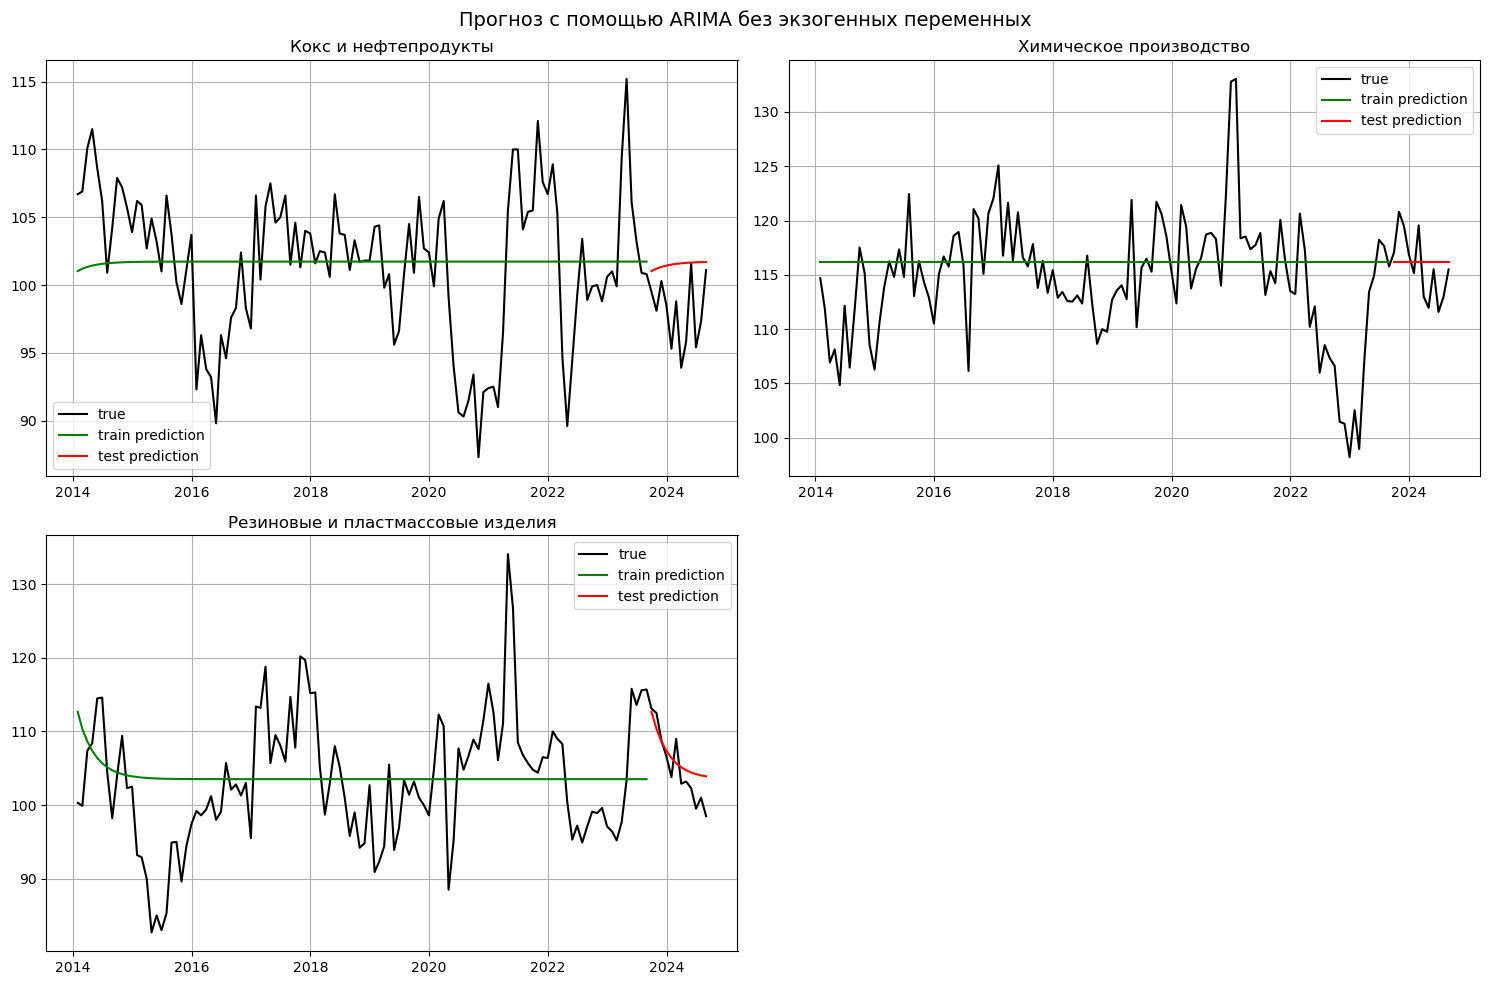

In [58]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

axes[0][0].plot(full.index, full['Подраздел DF Производство кокса , нефтепродуктов и ядерных материалов'], c='black', label='true')
axes[0][0].plot(cox_pred_train.index, cox_pred_train.arima_кокс, c='green', label='train prediction')
axes[0][0].plot(cox_pred_test.index, cox_pred_test.arima_кокс, c='red', label='test prediction')
axes[0][0].set_title('Кокс и нефтепродукты')
axes[0][0].grid()
axes[0][0].legend()

axes[1][0].plot(full.index, full['Подраздел DH Производство резиновых и пластмассовых  изделий'], c='black', label='true')
axes[1][0].plot(rez_pred_train.index, rez_pred_train.arima_резина, c='green', label='train prediction')
axes[1][0].plot(rez_pred_test.index, rez_pred_test.arima_резина, c='red', label='test prediction')
axes[1][0].set_title('Резиновые и пластмассовые изделия')
axes[1][0].grid()
axes[1][0].legend()

axes[0][1].plot(full.index, full['Подраздел DG Химическое производство'], c='black', label='true')
axes[0][1].plot(chem_pred_train.index, chem_pred_train.arima_химия, c='green', label='train prediction')
axes[0][1].plot(chem_pred_test.index, chem_pred_test.arima_химия, c='red', label='test prediction')
axes[0][1].set_title('Химическое производство')
axes[0][1].grid()
axes[0][1].legend()

fig.delaxes(axes[1][1])

fig.suptitle('Прогноз с помощью ARIMA без экзогенных переменных', fontsize=14)
plt.tight_layout()
# plt.savefig('new/var_graphs0.png')
plt.show()

In [62]:
cox_preds = pd.concat([test_prediction, cox_arimax_test, cox_arimax_test, rez_arimax_test, chem_pred_test, rez_pred_test, chem_pred_test], axis=1)

In [66]:
cox_m = pd.concat([test_prediction.var_кокс, cox_arimax_test, cox_pred_test], axis=1)
rez_m = pd.concat([test_prediction.var_резина, rez_arimax_test, rez_pred_test], axis=1)
chem_m = pd.concat([test_prediction.var_химия, chem_arimax_test, chem_pred_test], axis=1)

In [86]:
data[1].columns

Index(['Подраздел DG Химическое производство',
       'Подраздел DF Производство кокса , нефтепродуктов и ядерных материалов',
       'Подраздел DH Производство резиновых и пластмассовых  изделий'],
      dtype='object')

In [76]:
cox_m.columns = ['var', 'arimax', 'arima']
rez_m.columns = ['var', 'arimax', 'arima']
chem_m.columns = ['var', 'arimax', 'arima']

In [88]:
preds_list = [
    ('кокс', cox_m, data[1]['Подраздел DF Производство кокса , нефтепродуктов и ядерных материалов']),
    ('резина', rez_m, data[1]['Подраздел DH Производство резиновых и пластмассовых  изделий']),
    ('химия', chem_m, data[1]['Подраздел DG Химическое производство'])
]

mape_results = {
    'target': [],
    'var': [],
    'arimax': [],
    'arima': []
}

for name, preds, true_values in preds_list:
    mape_results['target'].append(name)
    for model in ['var', 'arimax', 'arima']:
        mape = mean_absolute_percentage_error(true_values, preds[model]) * 100 
        mape_results[model].append(round(mape, 2))

mape_table = pd.DataFrame(mape_results)
mape_table.set_index('target', inplace=True)
print(mape_table)

         var  arimax  arima
target                     
кокс    3.16    5.70   3.67
резина  7.46   22.93   2.30
химия   3.73    7.13   2.20


In [ ]:
# mape

In [ ]:
# графики для внутривыборочного прогноза и теста для вар

# N-BEATS / N-BEATSx / N-HITS

In [11]:
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS

import neuralforecast
print(neuralforecast.__version__)

import pytorch_lightning
print(pytorch_lightning.__version__)

2025-05-19 12:01:19,050	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-05-19 12:01:19,151	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


3.0.0
2.5.1


## N-HITS для нескольких таргетов

In [12]:
test_news_index = macro['Новостной индекс ЦБ']
test_df = model_data(['химия', 'кокс'], news_index=test_news_index)
train_features, test_features, train_target, test_target = test_df

In [13]:
def prepare_nf_long_format(train_features, test_features, train_target, test_target):
    # Склеиваем train и test отдельно по features и target
    features_all = pd.concat([train_features, test_features])
    targets_all = pd.concat([train_target, test_target])

    # Проверяем что индексы совпадают (дата)
    assert (features_all.index == targets_all.index).all(), "Индексы (дата) должны совпадать"
    
    # Результирующие списки
    dfs = []
    for target_name in targets_all.columns:
        # Формируем DataFrame для одного таргета
        df = pd.DataFrame({
            'unique_id': target_name,
            'ds': targets_all.index,
            'y': targets_all[target_name].values
        })
        # Добавляем фичи
        for col in features_all.columns:
            df[col] = features_all[col].values
        dfs.append(df)
    
    # Склеиваем в один DataFrame
    result = pd.concat(dfs, ignore_index=True)
    return result


In [14]:
long_df = prepare_nf_long_format(train_features, test_features, train_target, test_target)
long_df.unique_id = long_df.unique_id.replace(inverse_d)

In [15]:
# long_df

In [16]:

models = [
    NHITS(
        input_size=12,
        h=3,
#         stack_types=['identity'],
#         n_blocks=[1],
#         n_layers=[1],
#         n_theta=[2],
# #         mlp_units=[[ [32] ]],        
#         n_pool_kernel_size=[[2]],
#         n_freq_downsample=[[1]],
#         max_steps=5,
#         batch_size=4,
#         scaler_type='identity',
#         learning_rate=1e-2,
    )
]


nf = NeuralForecast(models=models, freq='M')  # 'MS' — начало месяца
# nf.fit(df=long_df)

Seed set to 1


In [17]:
cv_df = nf.cross_validation(long_df,
                            n_windows=10,
                            step_size=1,
                            verbose=0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

2025-05-19 12:01:28.403140: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-19 12:01:29.417351: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0

Epoch 99: 100%|█| 1/1 [00:00<00:00, 41.19it/s, v_num=230, train_loss_step=3.520,
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|████████████████████| 1/1 [00:00<00:00, 93.29it/s]
Epoch 199: 100%|█| 1/1 [00:00<00:00, 52.97it/s, v_num=230, train_loss_step=3.530
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████| 1/1 [00:00<00:00, 167.20it/s]
Epoch 299: 100%|█| 1/1 [00:00<00:00, 52.83it/s, v_num=230, train_loss_step=3.670
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████| 1/1 [00:00<00:00, 103.73it/s]
Epoch 399: 100%|█| 1/1 [00:00<00:00, 67.06it/s, v_num=230, train_loss_step=3.390
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████| 1/1 [00:00<00:00, 114.21it/s]
Epoch 499: 100%|█| 1/1 [00:0

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|█| 1/1 [00:00<00:00, 17.39it/s, v_num=230, train_loss_step=1.630


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-05-19 12:02:04.299284: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-19 12:02:05.447043: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|████████████████████| 1/1 [00:00<00:00,  5.77it/s]


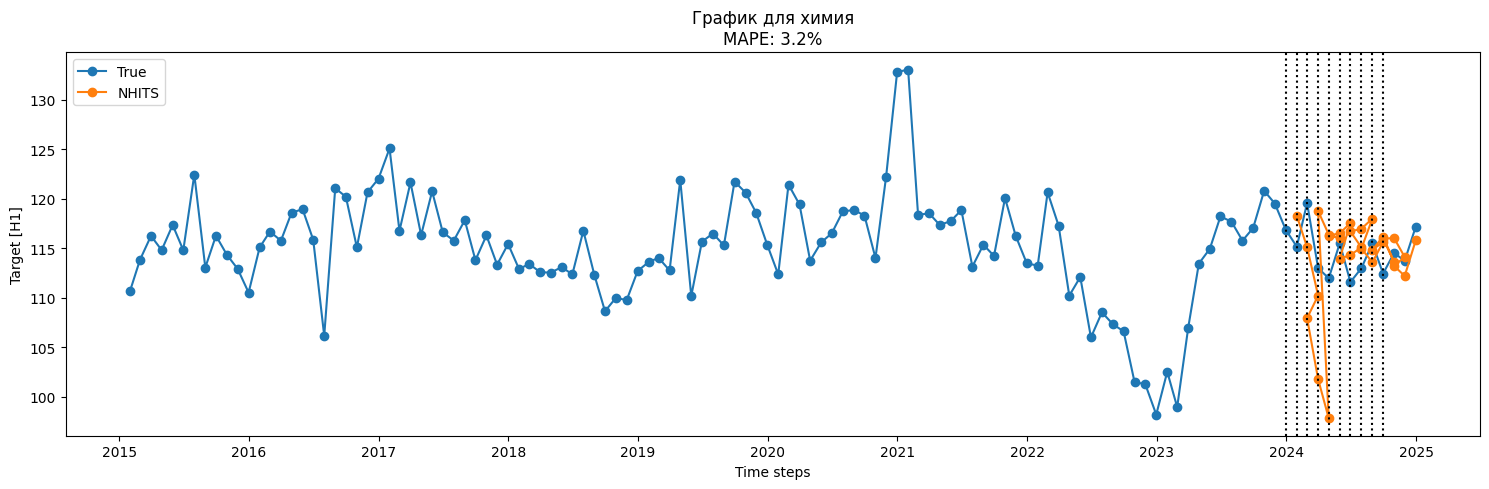

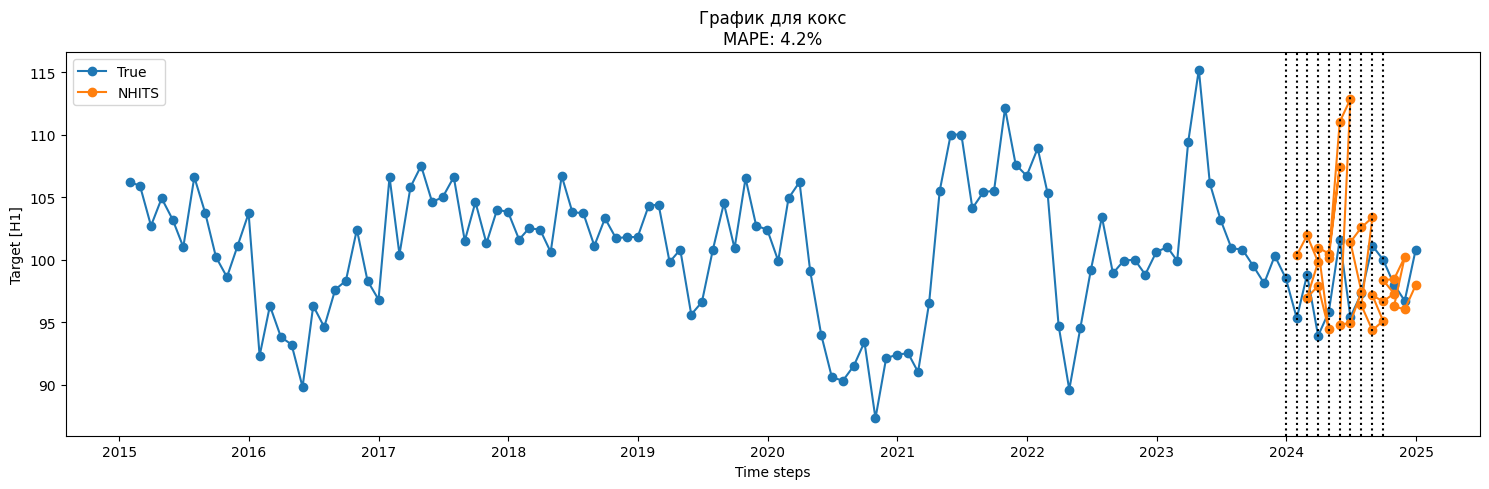

In [18]:
import matplotlib.pyplot as plt

for unique_id in long_df['unique_id'].unique():
    # Фильтруем данные
    ld = long_df[long_df['unique_id'] == unique_id]
    cv = cv_df[cv_df['unique_id'] == unique_id]
    cutoffs = cv['cutoff'].unique()

    plt.figure(figsize=(15,5))
    mape_nhits = mean_absolute_percentage_error(cv['y'], cv['NHITS'])
    plt.plot(ld['ds'], ld['y'], '-o', label='True')
    plt.plot(cv['ds'], cv['NHITS'], '-o', label='NHITS')

    for cutoff in cutoffs:
        plt.axvline(x=cutoff, color='black', ls=':')

    plt.xlabel('Time steps')
    plt.ylabel('Target [H1]')
    plt.title(f'График для {unique_id}\nMAPE: {100*np.round(mape_nhits,3)}%')
    plt.legend()
    plt.tight_layout()
    plt.show()


### Внутривыборочный прогноз

In [37]:
def get_in_sample_predictions(nf, long_df, h=1):
    """
    nf      - обученная NeuralForecast модель
    long_df - датафрейм, на котором модель была обучена
    h       - горизонт прогноза (обычно 1)
    """
    all_preds = []
    unique_ids = long_df['unique_id'].unique()
    for unique_id in unique_ids:
        df_id = long_df[long_df['unique_id'] == unique_id].copy()
        preds = []
        # идём по всем датам, строим one-step-ahead forecast
        for t in tqdm(range(nf.models[0].input_size, len(df_id))):
            df_hist = df_id.iloc[:t]   # только до t
            # для exogenous нужно оставить все нужные колонки
            pred = nf.predict(df=df_hist)
            # Получаем только первое значение прогноза (текущую точку)
            pred_one = pred.iloc[0]
            pred_one['true_y'] = df_id.iloc[t]['y']
            preds.append(pred_one)
        all_preds.append(pd.DataFrame(preds))
    return pd.concat(all_preds, ignore_index=True)


  0%|                                                     | 0/108 [00:00<?, ?it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████████████████| 1/1 [00:00<00:00, 18.72it/s]

  1%|▍                                            | 1/108 [00:00<00:32,  3.32it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 204.22it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 115.36it/s]


  3%|█▎                                           | 3/108 [00:00<00:13,  8.06it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 170.76it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 150.61it/s]


  5%|██                                           | 5/108 [00:00<00:09, 10.31it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 121.83it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 116.54it/s]


  6%|██▉                                          | 7/108 [00:00<00:08, 12.19it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 206.64it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 118.96it/s]

  8%|███▊                                         | 9/108 [00:00<00:07, 13.64it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 124.71it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 231.24it/s]

 10%|████▍                                       | 11/108 [00:00<00:06, 14.96it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 233.76it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 177.82it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 166.88it/s]


 13%|█████▋                                      | 14/108 [00:01<00:05, 16.73it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 219.98it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 171.64it/s]

 15%|██████▌                                     | 16/108 [00:01<00:05, 17.29it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 226.13it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 207.15it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 217.69it/s]

 18%|███████▋                                    | 19/108 [00:01<00:04, 19.38it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 112.38it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 110.33it/s]

 19%|████████▌                                   | 21/108 [00:01<00:04, 17.91it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 178.15it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 230.81it/s]

 21%|█████████▎                                  | 23/108 [00:01<00:04, 18.21it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 196.51it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 232.90it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 135.77it/s]


 24%|██████████▌                                 | 26/108 [00:01<00:04, 18.46it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 171.31it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 205.97it/s]

 26%|███████████▍                                | 28/108 [00:01<00:04, 17.79it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 231.37it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 218.85it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 141.43it/s]

 29%|████████████▋                               | 31/108 [00:01<00:03, 19.47it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 133.82it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 138.10it/s]

 31%|█████████████▍                              | 33/108 [00:02<00:04, 17.91it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 130.93it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 179.73it/s]


 32%|██████████████▎                             | 35/108 [00:02<00:04, 17.33it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 210.28it/s]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 206.26it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 199.30it/s]


 35%|███████████████▍                            | 38/108 [00:02<00:03, 19.20it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 209.19it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 226.01it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 222.37it/s]

 38%|████████████████▋                           | 41/108 [00:02<00:03, 20.04it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 216.15it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 118.43it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 177.23it/s]


 41%|█████████████████▉                          | 44/108 [00:02<00:03, 18.15it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 196.47it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 221.11it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 217.76it/s]


 44%|███████████████████▏                        | 47/108 [00:02<00:03, 19.42it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 154.24it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 216.10it/s]


 45%|███████████████████▉                        | 49/108 [00:02<00:03, 19.40it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 207.99it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 232.78it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 232.01it/s]

 48%|█████████████████████▏                      | 52/108 [00:03<00:02, 20.80it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 148.56it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 190.71it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 217.58it/s]

 51%|██████████████████████▍                     | 55/108 [00:03<00:02, 21.14it/s]GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 222.99it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 127.37it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 221.77it/s]


 54%|███████████████████████▋                    | 58/108 [00:03<00:02, 20.47it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████████████████| 1/1 [00:00<00:00, 91.44it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 128.00it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 158.29it/s]

 56%|████████████████████████▊                   | 61/108 [00:03<00:02, 17.78it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 219.71it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 182.51it/s]


 58%|█████████████████████████▋                  | 63/108 [00:03<00:02, 17.83it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 187.10it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 160.48it/s]

 60%|██████████████████████████▍                 | 65/108 [00:03<00:02, 18.24it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 223.54it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 125.63it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 121.49it/s]

 63%|███████████████████████████▋                | 68/108 [00:03<00:02, 17.93it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 113.66it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 166.69it/s]

 65%|████████████████████████████▌               | 70/108 [00:04<00:02, 16.64it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 114.82it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 231.52it/s]

 67%|█████████████████████████████▎              | 72/108 [00:04<00:02, 16.10it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 219.44it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 222.67it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 225.99it/s]


 69%|██████████████████████████████▌             | 75/108 [00:04<00:01, 18.40it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 209.69it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 210.74it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 208.15it/s]

 72%|███████████████████████████████▊            | 78/108 [00:04<00:01, 20.03it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 208.83it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 230.43it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 221.92it/s]

 75%|█████████████████████████████████           | 81/108 [00:04<00:01, 21.24it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 223.17it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 201.42it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 194.91it/s]

 78%|██████████████████████████████████▏         | 84/108 [00:04<00:01, 21.86it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 233.68it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 173.35it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 224.75it/s]

 81%|███████████████████████████████████▍        | 87/108 [00:04<00:00, 22.39it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 226.34it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 200.94it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 206.20it/s]

 83%|████████████████████████████████████▋       | 90/108 [00:04<00:00, 21.98it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 150.78it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|██████████████████████| 1/1 [00:00<00:00, 97.15it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 224.67it/s]

 86%|█████████████████████████████████████▉      | 93/108 [00:05<00:00, 20.73it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 233.11it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 206.61it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 231.12it/s]

 89%|███████████████████████████████████████     | 96/108 [00:05<00:00, 21.73it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 152.95it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 231.70it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 225.85it/s]


 92%|████████████████████████████████████████▎   | 99/108 [00:05<00:00, 21.07it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 230.85it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 210.58it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 158.71it/s]


 94%|████████████████████████████████████████▌  | 102/108 [00:05<00:00, 20.50it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 114.18it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 102.17it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 215.40it/s]

 97%|█████████████████████████████████████████▊ | 105/108 [00:05<00:00, 19.20it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 128.14it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 143.17it/s]

 99%|██████████████████████████████████████████▌| 107/108 [00:05<00:00, 17.31it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 194.60it/s]

100%|███████████████████████████████████████████| 108/108 [00:05<00:00, 18.07it/s]


  0%|                                                     | 0/108 [00:00<?, ?it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 131.68it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 221.22it/s]


  2%|▊                                            | 2/108 [00:00<00:05, 17.89it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 219.51it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 213.27it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 206.64it/s]

  5%|██                                           | 5/108 [00:00<00:04, 21.55it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 231.58it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 231.91it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 116.11it/s]

  7%|███▎                                         | 8/108 [00:00<00:04, 22.15it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 109.08it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 106.52it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 187.61it/s]

 10%|████▍                                       | 11/108 [00:00<00:05, 18.02it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 231.14it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 123.46it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 135.64it/s]

 13%|█████▋                                      | 14/108 [00:00<00:05, 18.53it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 127.89it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 203.84it/s]

 15%|██████▌                                     | 16/108 [00:00<00:04, 18.84it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 219.67it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 221.80it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 169.95it/s]


 18%|███████▋                                    | 19/108 [00:00<00:04, 19.89it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 226.35it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 224.55it/s]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 160.42it/s]


 20%|████████▉                                   | 22/108 [00:01<00:04, 19.84it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 227.53it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 186.55it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 180.14it/s]

 23%|██████████▏                                 | 25/108 [00:01<00:04, 18.78it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 190.96it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 231.17it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 130.27it/s]

 26%|███████████▍                                | 28/108 [00:01<00:04, 19.23it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 123.45it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 111.90it/s]

 28%|████████████▏                               | 30/108 [00:01<00:04, 17.12it/s]GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 141.91it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 115.03it/s]

 30%|█████████████                               | 32/108 [00:01<00:04, 16.72it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 149.99it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 172.51it/s]

 31%|█████████████▊                              | 34/108 [00:01<00:04, 15.51it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 185.43it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 225.95it/s]


 33%|██████████████▋                             | 36/108 [00:01<00:04, 16.34it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 275.94it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 282.12it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 196.98it/s]

 36%|███████████████▉                            | 39/108 [00:02<00:03, 17.99it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 309.70it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 176.39it/s]


 38%|████████████████▋                           | 41/108 [00:02<00:03, 18.43it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 209.81it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 232.37it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 148.77it/s]


 41%|█████████████████▉                          | 44/108 [00:02<00:03, 19.21it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 117.62it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 117.71it/s]


 43%|██████████████████▋                         | 46/108 [00:02<00:03, 17.73it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████████████████| 1/1 [00:00<00:00, 94.80it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 183.90it/s]

 44%|███████████████████▌                        | 48/108 [00:02<00:03, 16.08it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 204.44it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 220.67it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 161.65it/s]

 47%|████████████████████▊                       | 51/108 [00:02<00:03, 17.40it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 129.75it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 185.14it/s]

 49%|█████████████████████▌                      | 53/108 [00:02<00:03, 16.94it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 181.52it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 201.92it/s]


 51%|██████████████████████▍                     | 55/108 [00:03<00:03, 17.08it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 238.83it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 216.00it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 224.97it/s]


 54%|███████████████████████▋                    | 58/108 [00:03<00:02, 19.06it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 236.66it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 224.10it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 234.74it/s]

 56%|████████████████████████▊                   | 61/108 [00:03<00:02, 20.58it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 220.74it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 223.37it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 120.36it/s]

 59%|██████████████████████████                  | 64/108 [00:03<00:02, 21.29it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 156.54it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 228.40it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 191.84it/s]

 62%|███████████████████████████▎                | 67/108 [00:03<00:02, 20.35it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 212.81it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|██████████████████████| 1/1 [00:00<00:00, 99.03it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 219.56it/s]

 65%|████████████████████████████▌               | 70/108 [00:03<00:01, 19.20it/s]GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 136.13it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 105.35it/s]

 67%|█████████████████████████████▎              | 72/108 [00:03<00:01, 18.45it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 182.28it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 212.61it/s]

 69%|██████████████████████████████▏             | 74/108 [00:04<00:01, 18.23it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 219.30it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 202.33it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 215.42it/s]

 71%|███████████████████████████████▎            | 77/108 [00:04<00:01, 19.84it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 192.06it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 175.44it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 281.38it/s]

 74%|████████████████████████████████▌           | 80/108 [00:04<00:01, 20.37it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 267.82it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 210.80it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 197.93it/s]

 77%|█████████████████████████████████▊          | 83/108 [00:04<00:01, 20.56it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 212.88it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 233.51it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 207.64it/s]


 80%|███████████████████████████████████         | 86/108 [00:04<00:01, 20.53it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 175.58it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 193.67it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 213.68it/s]

 82%|████████████████████████████████████▎       | 89/108 [00:04<00:00, 19.52it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 225.86it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 226.41it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 157.15it/s]


 85%|█████████████████████████████████████▍      | 92/108 [00:04<00:00, 20.03it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 234.50it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 233.72it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 188.37it/s]

 88%|██████████████████████████████████████▋     | 95/108 [00:05<00:00, 20.99it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 128.19it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 173.48it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 119.33it/s]

 91%|███████████████████████████████████████▉    | 98/108 [00:05<00:00, 20.18it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 238.26it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 231.61it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 115.88it/s]

 94%|████████████████████████████████████████▏  | 101/108 [00:05<00:00, 20.51it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 181.56it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 202.97it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 185.93it/s]

 96%|█████████████████████████████████████████▍ | 104/108 [00:05<00:00, 18.33it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 192.36it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 225.03it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 199.24it/s]

 99%|██████████████████████████████████████████▌| 107/108 [00:05<00:00, 19.49it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 194.50it/s]

100%|███████████████████████████████████████████| 108/108 [00:05<00:00, 18.98it/s]

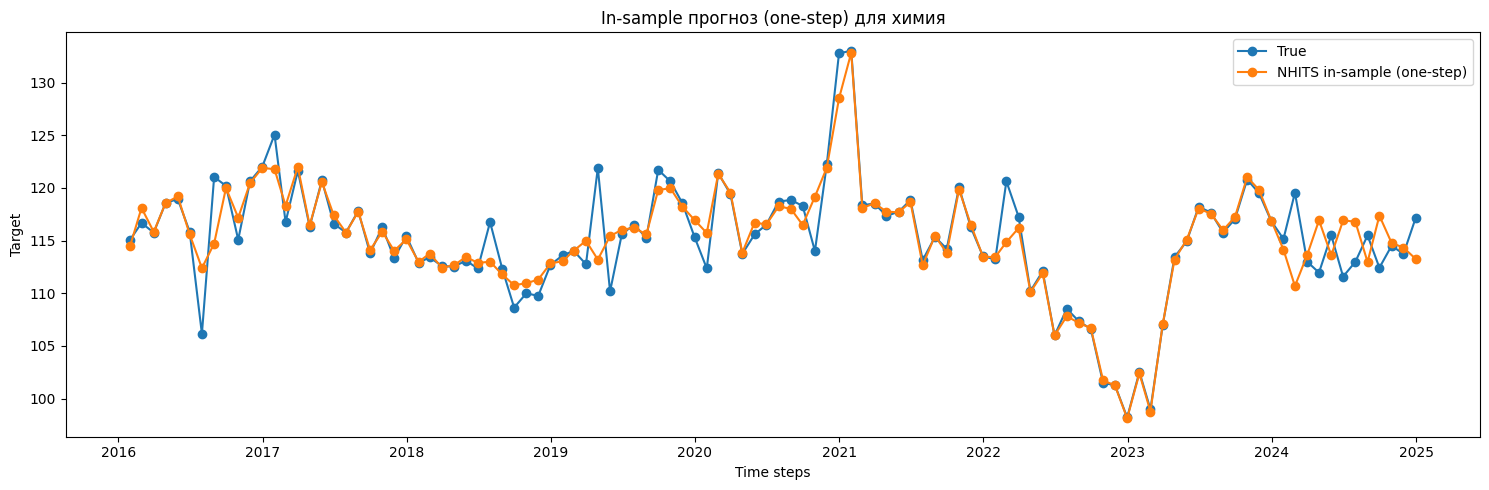

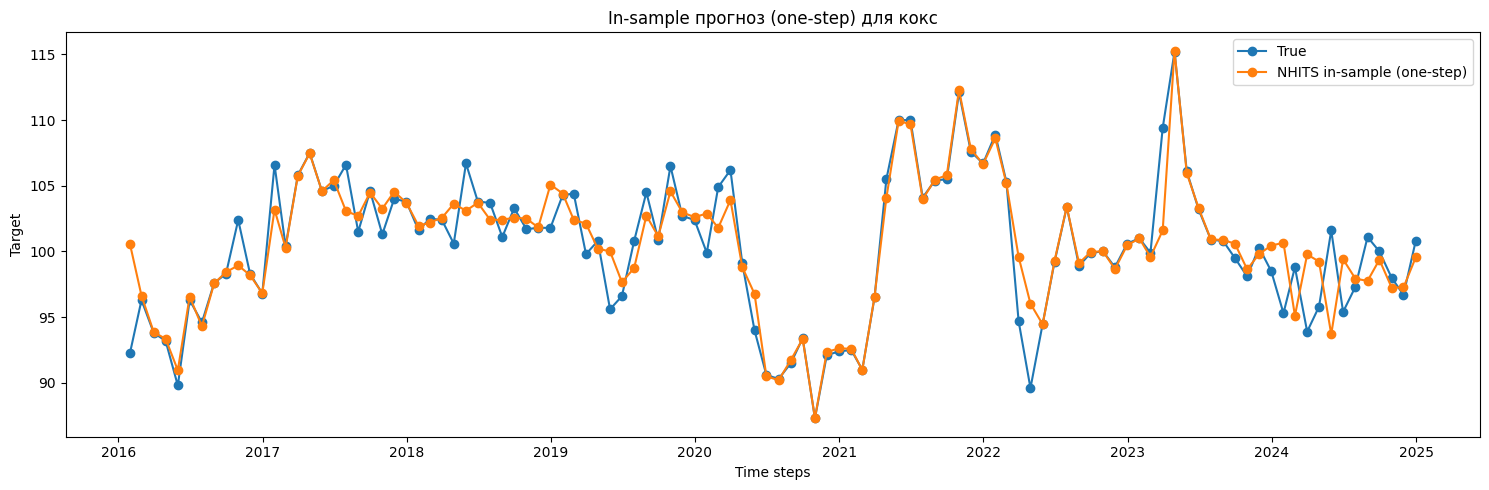

In [38]:
# Получаем "one-step ahead" in-sample прогнозы
in_sample_pred = get_in_sample_predictions(nf, long_df, h=1)

# Визуализация
for unique_id in long_df['unique_id'].unique():
    data = in_sample_pred[in_sample_pred['unique_id'] == unique_id]
    plt.figure(figsize=(15,5))
    plt.plot(data['ds'], data['true_y'], '-o', label='True')
    plt.plot(data['ds'], data['NHITS'], '-o', label='NHITS in-sample (one-step)')
    plt.xlabel('Time steps')
    plt.ylabel('Target')
    plt.title(f'In-sample прогноз (one-step) для {unique_id}')
    plt.legend()
    plt.tight_layout()
    plt.show()


## NHITS 1 таргет

In [16]:
test_news_index = macro['Новостной индекс ЦБ']
test_df = model_data(['химия'], news_index=test_news_index)
train_features, test_features, train_target, test_target = test_df

In [17]:
long_df = prepare_nf_long_format(train_features, test_features, train_target, test_target)
long_df.unique_id = long_df.unique_id.replace(inverse_d)

In [21]:

models = [
    NHITS(
        input_size=12,
        h=3,
    )
]


nf = NeuralForecast(models=models, freq='M')

Seed set to 1


In [22]:
cv_df = nf.cross_validation(long_df,
                            n_windows=4,
                            step_size=1,
                            verbose=0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

2025-05-18 14:25:34.354796: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-18 14:25:35.422992: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0

Epoch 99: 100%|█| 1/1 [00:00<00:00, 40.53it/s, v_num=223, train_loss_step=4.070, t
Validation: |                                               | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████| 1/1 [00:00<00:00, 99.15it/s]
Epoch 199: 100%|█| 1/1 [00:00<00:00, 42.81it/s, v_num=223, train_loss_step=3.760, 
Validation: |                                               | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 116.92it/s]
Epoch 299: 100%|█| 1/1 [00:00<00:00, 41.37it/s, v_num=223, train_loss_step=3.840, 
Validation: |                                               | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████| 1/1 [00:00<00:00, 94.46it/s]
Epoch 399: 100%|█| 1/1 [00:00<00:00, 61.45it/s, v_num=223, train_loss_step=3.330, 
Validation: |                                               | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████| 1/1 [00:00<00:00, 127.91it/s]
Epoc

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|█| 1/1 [00:00<00:00, 17.54it/s, v_num=223, train_loss_step=1.340, 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-05-18 14:26:04.419999: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-18 14:26:05.213704: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████████████████| 1/1 [00:00<00:00, 11.95it/s]


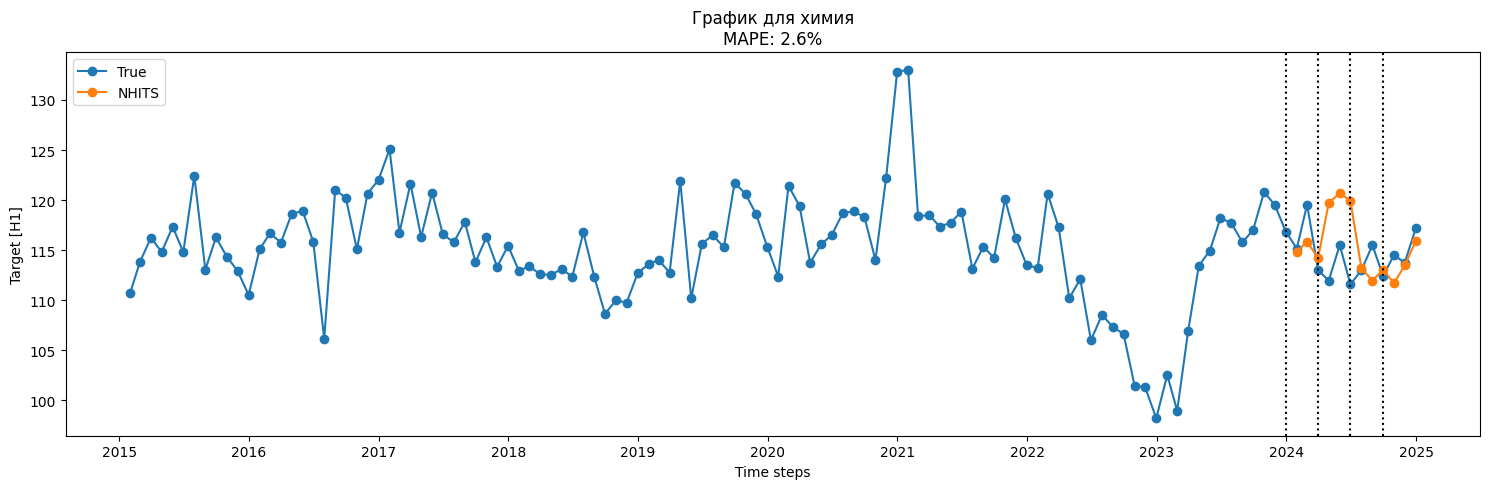

In [23]:
import matplotlib.pyplot as plt

for unique_id in long_df['unique_id'].unique():
    # Фильтруем данные
    ld = long_df[long_df['unique_id'] == unique_id]
    cv = cv_df[cv_df['unique_id'] == unique_id]
    cutoffs = cv['cutoff'].unique()

    plt.figure(figsize=(15,5))
    mape_nhits = mean_absolute_percentage_error(cv['y'], cv['NHITS'])
    plt.plot(ld['ds'], ld['y'], '-o', label='True')
    plt.plot(cv['ds'], cv['NHITS'], '-o', label='NHITS')

    for cutoff in cutoffs:
        plt.axvline(x=cutoff, color='black', ls=':')

    plt.xlabel('Time steps')
    plt.ylabel('Target [H1]')
    plt.title(f'График для {unique_id}\nMAPE: {100*np.round(mape_nhits,3)}%')
    plt.legend()
    plt.tight_layout()
    plt.show()


## old

In [435]:
def data_nn(name: str):
    
#     train_features, test_features, train_target, test_target = model_data(name, forecast_horizon=24)
    train_df = pd.concat([train_features, train_target], axis=1).reset_index()
    name_train = train_df[['date', 
                             features_dict[name][0], 
                             target_dict[name]]].fillna(0)
    name_train.rename(columns={
                                'date': 'ds', 
                                features_dict[name][0]: 'feat1',
                                target_dict[name]: 'y'
                                 }, inplace=True)
    name_train['unique_id'] = 0

    
    test_df = pd.concat([test_features, test_target], axis=1).reset_index()
    name_test = test_df[['date', 
                             features_dict[name][0], 
                             target_dict[name]]].fillna(0)
    name_test.rename(columns={
                                'date': 'ds', 
                                features_dict[name][0]: 'feat1',
                                target_dict[name]: 'y'
                                 }, inplace=True)
    name_test['unique_id'] = 0

    
    return (name_train, name_test)

In [437]:
# cox_info = data_nn('кокс')
# rez_info = data_nn('резина')
# chem_info = data_nn('химия')

In [300]:
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast.losses.pytorch import DistributionLoss

from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss

from neuralforecast.models import NHITS

import matplotlib.pyplot as plt

In [302]:
# ?NBEATS

In [304]:
nbeats = NBEATS(h=24, input_size=36,
               loss=DistributionLoss(distribution='Normal', level=[80, 90]),  # Poisson dist falls with The operator 'aten::poisson' is not currently implemented for the MPS device.
               stack_types = ['identity', 'trend', 'seasonality'],
               max_steps=100,
               val_check_steps=10,
               early_stop_patience_steps=2)

nbeatsx = NBEATSx(h=24, input_size=36,
                loss=MQLoss(level=[80, 90]),
                scaler_type='standard',  # robust falls with the same issue
                dropout_prob_theta=0.5,
                # stat_exog_list=['airline1'],
                futr_exog_list=['feat1'],
                max_steps=200,
                val_check_steps=10,
                early_stop_patience_steps=2)

nhits = NHITS(h=24,
              input_size=36,
              loss=DistributionLoss(distribution='Normal', level=[80, 90], return_params=True), # StudentT falls 
              # stat_exog_list=['airline1'],
              futr_exog_list=['feat1'],
              n_freq_downsample=[2, 1, 1],
              scaler_type='standard',     # robust falls
              max_steps=200,
              early_stop_patience_steps=2,
              inference_windows_batch_size=1,
              val_check_steps=10,
              learning_rate=1e-3)

Seed set to 1
Seed set to 1
Seed set to 1


In [306]:
def pred_nn(model_nn, cox_info, rez_info, chem_info):
    
    nf = NeuralForecast(
        models=[model_nn],
        freq='ME'
    )
    nf.fit(df=cox_info[0], val_size=24)
    cox_nbeats_test = nf.predict(futr_df=cox_info[1])
    
    nf = NeuralForecast(
        models=[model_nn],
        freq='ME'
    )
    nf.fit(df=rez_info[0], val_size=24)
    rez_nbeats_test = nf.predict(futr_df=rez_info[1])
    
    nf = NeuralForecast(
        models=[model_nn],
        freq='ME'
    )
    nf.fit(df=chem_info[0], val_size=24)
    chem_nbeats_test = nf.predict(futr_df=chem_info[1])
    
    return cox_nbeats_test, rez_nbeats_test, chem_nbeats_test

In [308]:
cox_nbeats_test, rez_nbeats_test, chem_nbeats_test = pred_nn(nbeats, cox_info, rez_info, chem_info)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | padder_train | ConstantPad1d    | 0      | train
2 | scaler       | TemporalNorm     | 0      | train
3 | blocks       | ModuleList       | 2.5 M  | train
----------------------------------------------------------
2.5 M     Trainable params
2.9 K     Non-trainable params
2.5 M     Total params
10.169    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | padder_train | ConstantPad1d    | 0      | train
2 | scaler       | TemporalNorm     | 0      | train
3 | blocks       | ModuleList       | 2.5 M  | train
----------------------------------------------------------
2.5 M     Trainable params
2.9 K     Non-trainable params
2.5 M     Total params
10.169    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | padder_train | ConstantPad1d    | 0      | train
2 | scaler       | TemporalNorm     | 0      | train
3 | blocks       | ModuleList       | 2.5 M  | train
----------------------------------------------------------
2.5 M     Trainable params
2.9 K     Non-trainable params
2.5 M     Total params
10.169    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

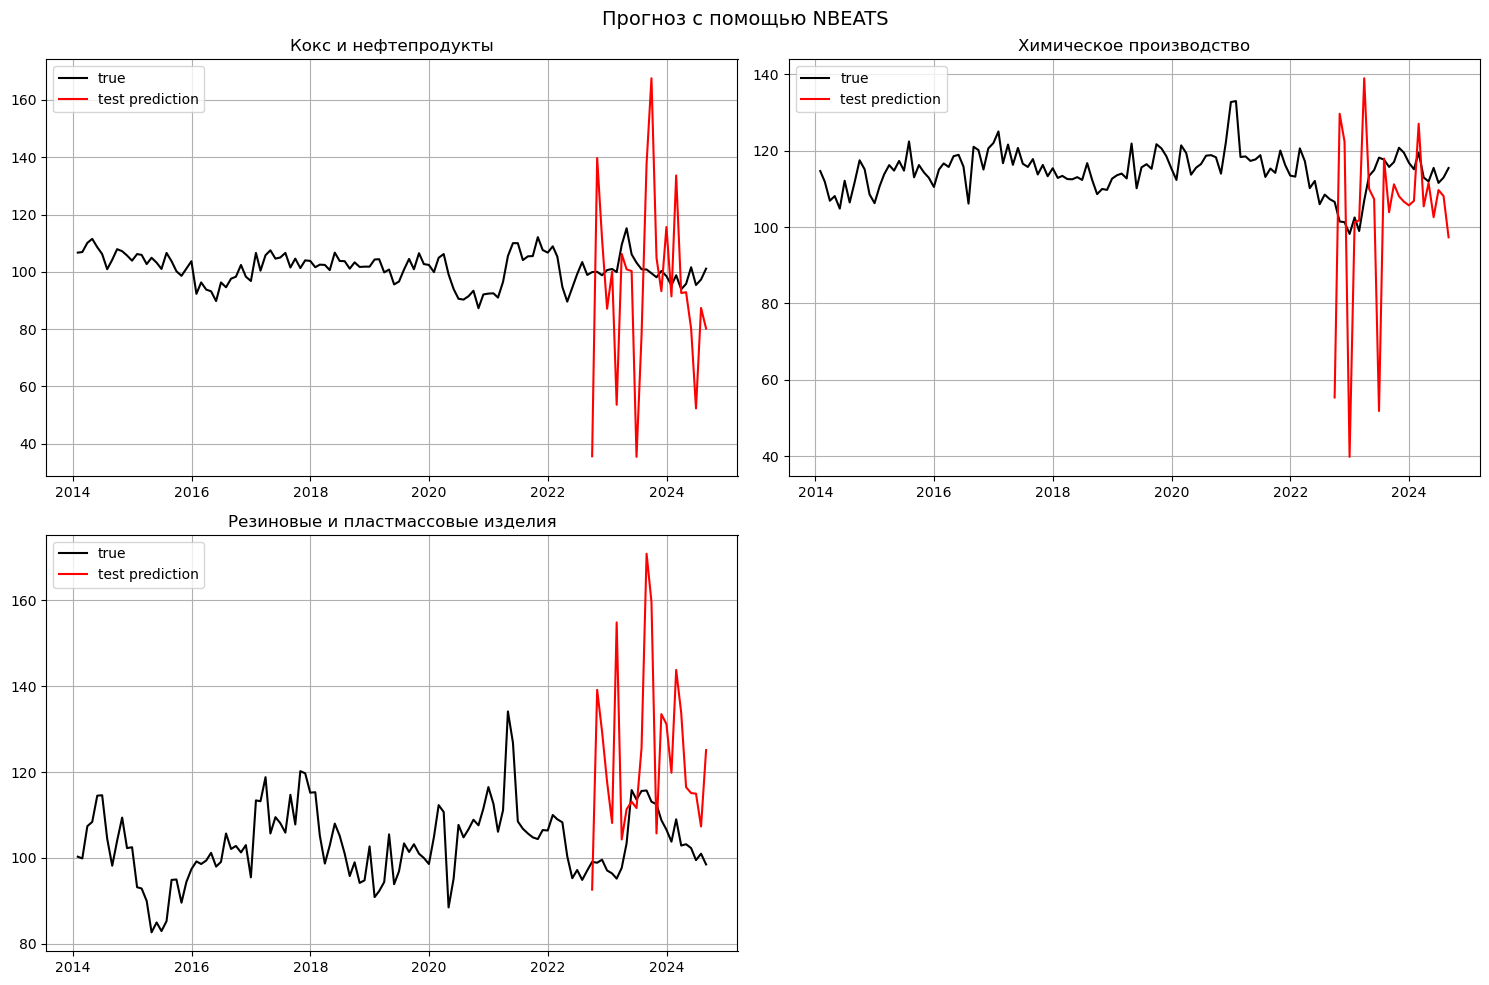

In [309]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

axes[0][0].plot(full.index, full['Подраздел DF Производство кокса , нефтепродуктов и ядерных материалов'], c='black', label='true')
# axes[0][0].plot(cox_nbeats_train.ds, cox_nbeats_train['NBEATS-median'], c='green', label='train prediction')
axes[0][0].plot(cox_nbeats_test.ds, cox_nbeats_test['NBEATS-median'], c='red', label='test prediction')
axes[0][0].set_title('Кокс и нефтепродукты')
axes[0][0].grid()
axes[0][0].legend()

axes[1][0].plot(full.index, full['Подраздел DH Производство резиновых и пластмассовых  изделий'], c='black', label='true')
# axes[1][0].plot(rez_pred_train.index, rez_pred_train.arima_prediction_резина, c='green', label='train prediction')
axes[1][0].plot(rez_nbeats_test.ds, rez_nbeats_test['NBEATS-median'], c='red', label='test prediction')
axes[1][0].set_title('Резиновые и пластмассовые изделия')
axes[1][0].grid()
axes[1][0].legend()

axes[0][1].plot(full.index, full['Подраздел DG Химическое производство'], c='black', label='true')
# axes[0][1].plot(chem_pred_train.index, chem_pred_train.arima_prediction_химия, c='green', label='train prediction')
axes[0][1].plot(chem_nbeats_test.ds, chem_nbeats_test['NBEATS-median'], c='red', label='test prediction')
axes[0][1].set_title('Химическое производство')
axes[0][1].grid()
axes[0][1].legend()

fig.delaxes(axes[1][1])

fig.suptitle('Прогноз с помощью NBEATS', fontsize=14)
plt.tight_layout()
# plt.savefig('new/var_graphs0.png')
plt.show()

In [316]:
cox_nbeatsx_test, rez_nbeatsx_test, chem_nbeatsx_test = pred_nn(nbeatsx, cox_info, rez_info, chem_info)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.7 M  | train
-------------------------------------------------------
2.7 M     Trainable params
2.9 K     Non-trainable params
2.7 M     Total params
10.987    Total estimated model params size (MB)
40        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.7 M  | train
-------------------------------------------------------
2.7 M     Trainable params
2.9 K     Non-trainable params
2.7 M     Total params
10.987    Total estimated model params size (MB)
40        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.7 M  | train
-------------------------------------------------------
2.7 M     Trainable params
2.9 K     Non-trainable params
2.7 M     Total params
10.987    Total estimated model params size (MB)
40        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

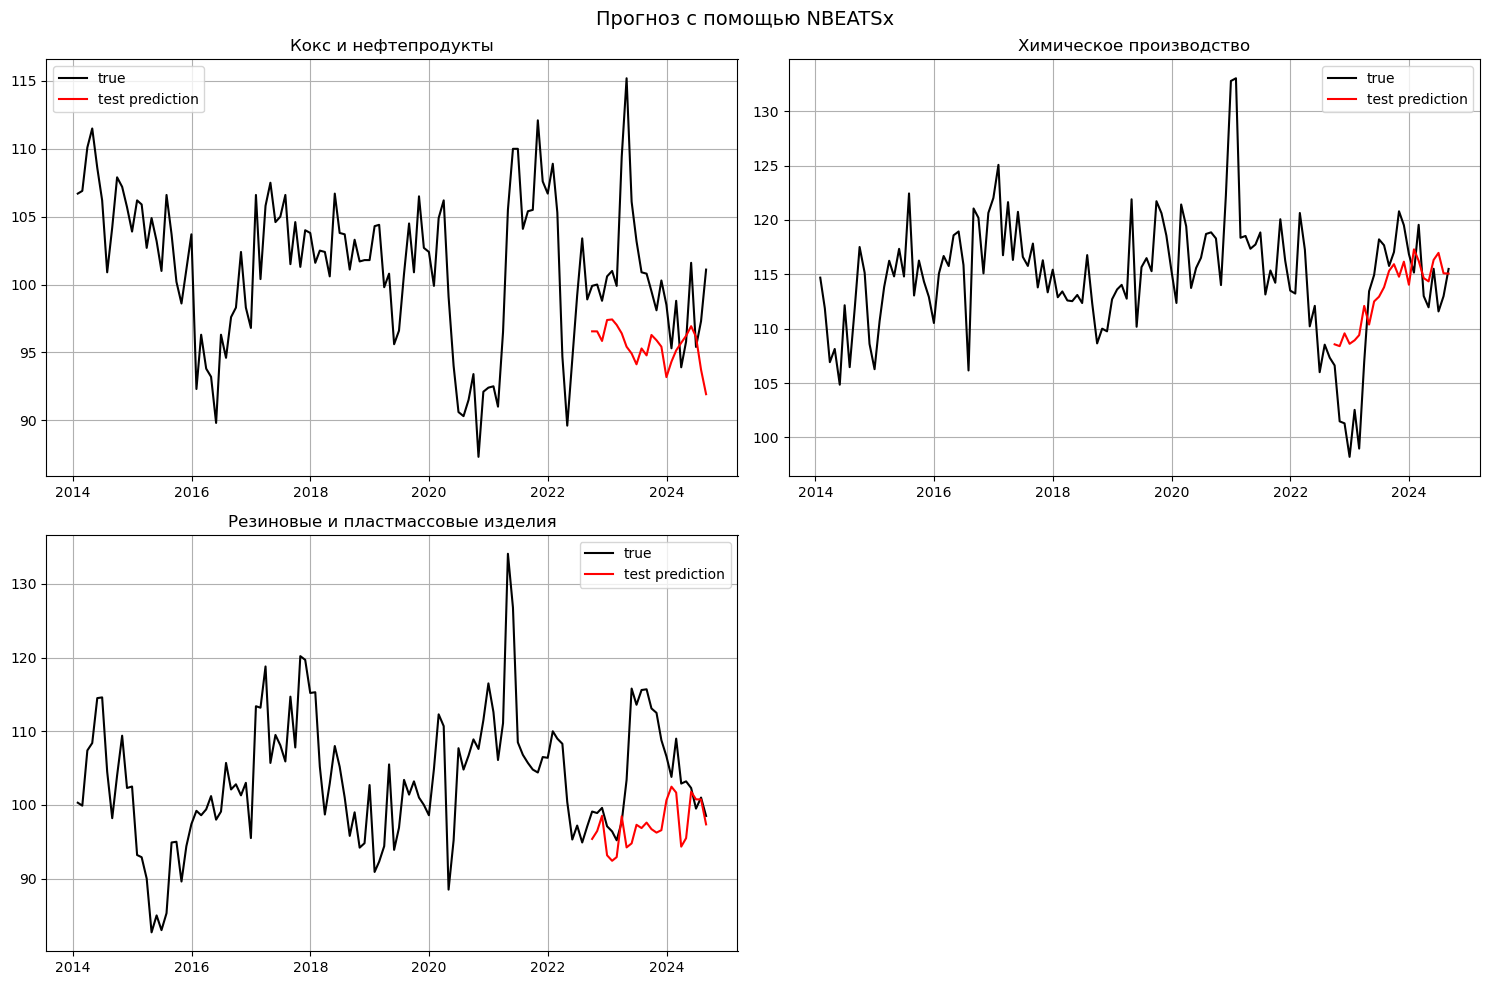

In [317]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

axes[0][0].plot(full.index, full['Подраздел DF Производство кокса , нефтепродуктов и ядерных материалов'], c='black', label='true')
# axes[0][0].plot(cox_nbeats_train.ds, cox_nbeats_train['NBEATS-median'], c='green', label='train prediction')
axes[0][0].plot(cox_nbeatsx_test.ds, cox_nbeatsx_test['NBEATSx-median'], c='red', label='test prediction')
axes[0][0].set_title('Кокс и нефтепродукты')
axes[0][0].grid()
axes[0][0].legend()

axes[1][0].plot(full.index, full['Подраздел DH Производство резиновых и пластмассовых  изделий'], c='black', label='true')
# axes[1][0].plot(rez_pred_train.index, rez_pred_train.arima_prediction_резина, c='green', label='train prediction')
axes[1][0].plot(rez_nbeatsx_test.ds, rez_nbeatsx_test['NBEATSx-median'], c='red', label='test prediction')
axes[1][0].set_title('Резиновые и пластмассовые изделия')
axes[1][0].grid()
axes[1][0].legend()

axes[0][1].plot(full.index, full['Подраздел DG Химическое производство'], c='black', label='true')
# axes[0][1].plot(chem_pred_train.index, chem_pred_train.arima_prediction_химия, c='green', label='train prediction')
axes[0][1].plot(chem_nbeatsx_test.ds, chem_nbeatsx_test['NBEATSx-median'], c='red', label='test prediction')
axes[0][1].set_title('Химическое производство')
axes[0][1].grid()
axes[0][1].legend()

fig.delaxes(axes[1][1])

fig.suptitle('Прогноз с помощью NBEATSx', fontsize=14)
plt.tight_layout()
# plt.savefig('new/var_graphs0.png')
plt.show()

In [320]:
cox_nhits_test, rez_nhits_test, chem_nhits_test = pred_nn(nhits, cox_info, rez_info, chem_info)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | padder_train | ConstantPad1d    | 0      | train
2 | scaler       | TemporalNorm     | 0      | train
3 | blocks       | ModuleList       | 2.6 M  | train
----------------------------------------------------------
2.6 M     Trainable params
5         Non-trainable params
2.6 M     Total params
10.323    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | padder_train | ConstantPad1d    | 0      | train
2 | scaler       | TemporalNorm     | 0      | train
3 | blocks       | ModuleList       | 2.6 M  | train
----------------------------------------------------------
2.6 M     Trainable params
5         Non-trainable params
2.6 M     Total params
10.323    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | padder_train | ConstantPad1d    | 0      | train
2 | scaler       | TemporalNorm     | 0      | train
3 | blocks       | ModuleList       | 2.6 M  | train
----------------------------------------------------------
2.6 M     Trainable params
5         Non-trainable params
2.6 M     Total params
10.323    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

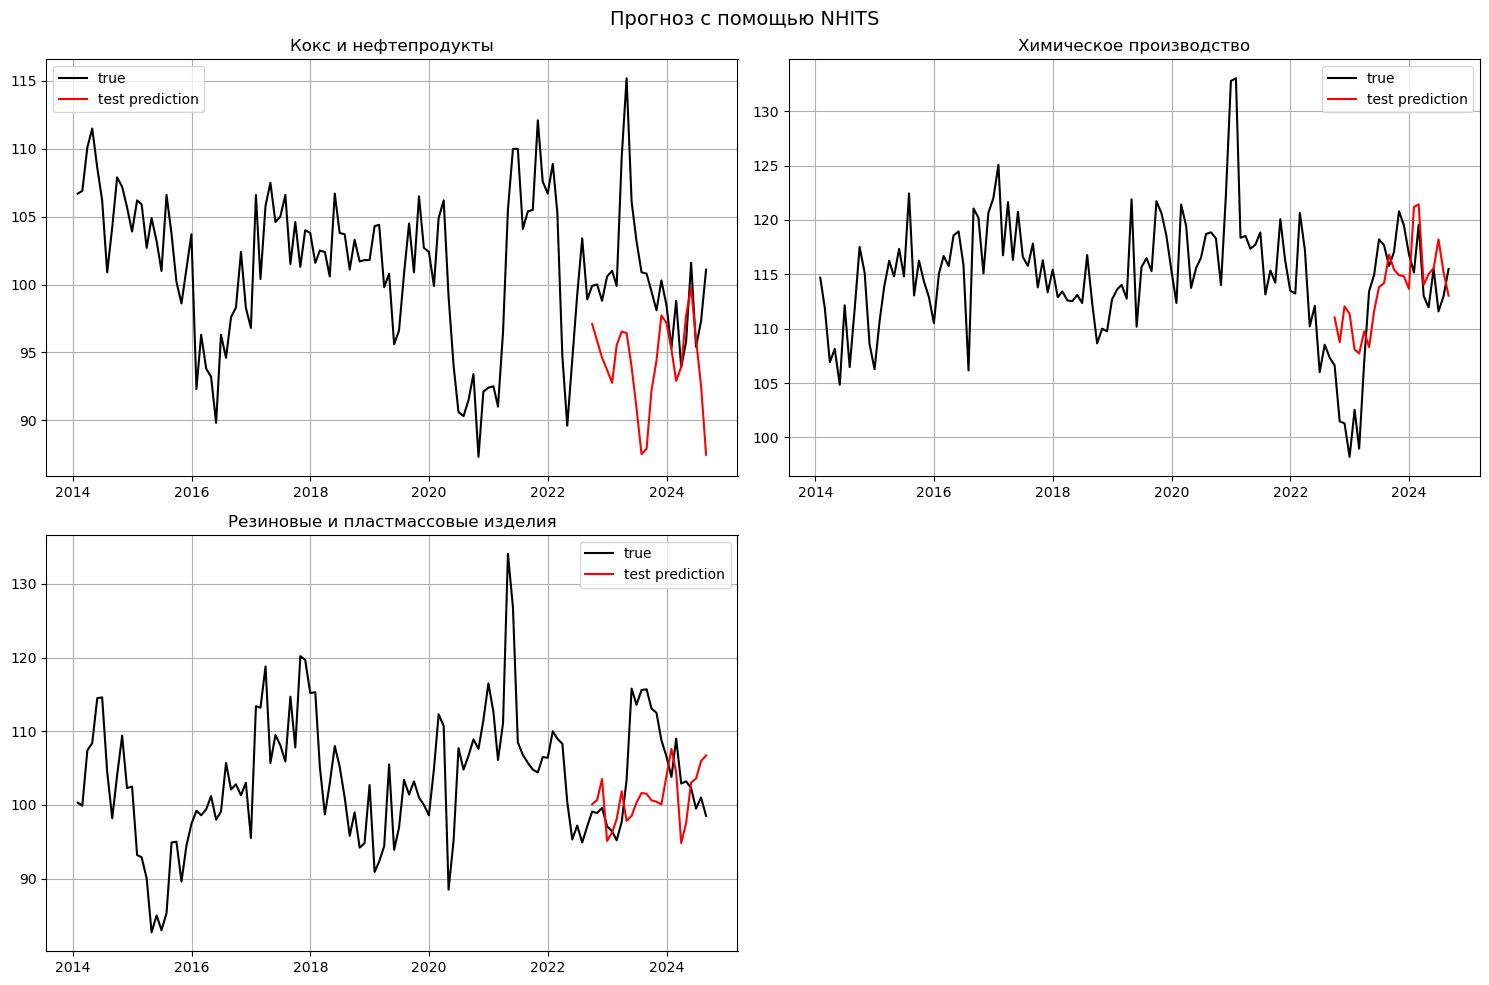

In [322]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

axes[0][0].plot(full.index, full['Подраздел DF Производство кокса , нефтепродуктов и ядерных материалов'], c='black', label='true')
# axes[0][0].plot(cox_nbeats_train.ds, cox_nbeats_train['NBEATS-median'], c='green', label='train prediction')
axes[0][0].plot(cox_nhits_test.ds, cox_nhits_test['NHITS-median'], c='red', label='test prediction')
axes[0][0].set_title('Кокс и нефтепродукты')
axes[0][0].grid()
axes[0][0].legend()

axes[1][0].plot(full.index, full['Подраздел DH Производство резиновых и пластмассовых  изделий'], c='black', label='true')
# axes[1][0].plot(rez_pred_train.index, rez_pred_train.arima_prediction_резина, c='green', label='train prediction')
axes[1][0].plot(rez_nhits_test.ds, rez_nhits_test['NHITS-median'], c='red', label='test prediction')
axes[1][0].set_title('Резиновые и пластмассовые изделия')
axes[1][0].grid()
axes[1][0].legend()

axes[0][1].plot(full.index, full['Подраздел DG Химическое производство'], c='black', label='true')
# axes[0][1].plot(chem_pred_train.index, chem_pred_train.arima_prediction_химия, c='green', label='train prediction')
axes[0][1].plot(chem_nhits_test.ds, chem_nhits_test['NHITS-median'], c='red', label='test prediction')
axes[0][1].set_title('Химическое производство')
axes[0][1].grid()
axes[0][1].legend()

fig.delaxes(axes[1][1])

fig.suptitle('Прогноз с помощью NHITS', fontsize=14)
plt.tight_layout()
# plt.savefig('new/var_graphs0.png')
plt.show()

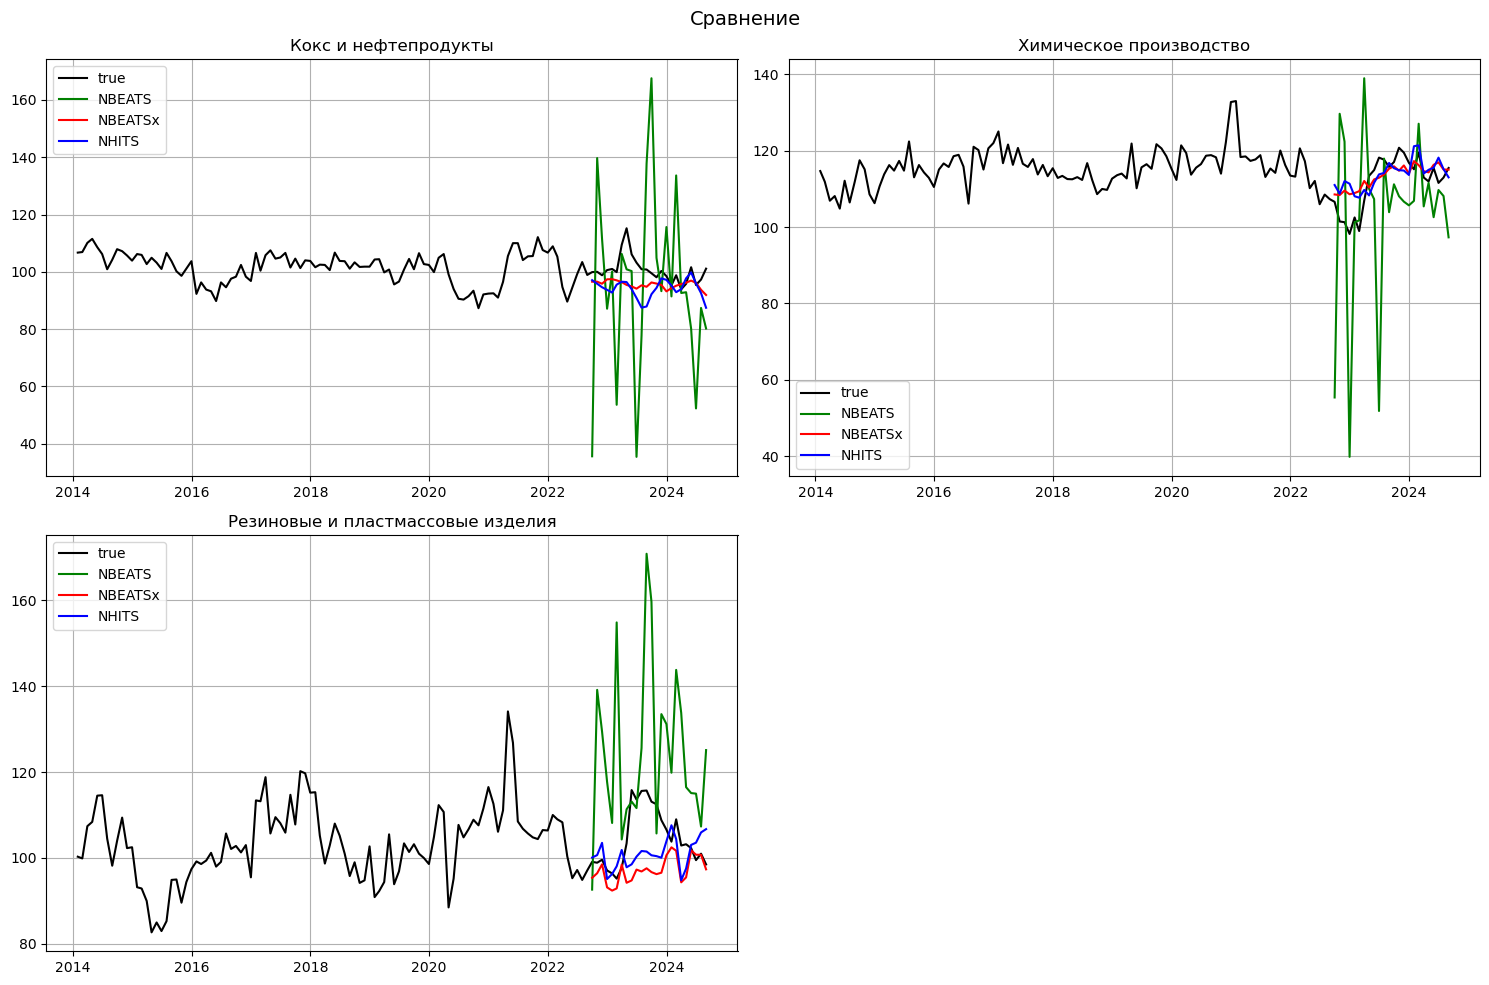

In [328]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

axes[0][0].plot(full.index, full['Подраздел DF Производство кокса , нефтепродуктов и ядерных материалов'], c='black', label='true')
# axes[0][0].plot(cox_nbeats_train.ds, cox_nbeats_train['NBEATS-median'], c='green', label='train prediction')
axes[0][0].plot(cox_nbeats_test.ds, cox_nbeats_test['NBEATS-median'], c='green', label='NBEATS')
axes[0][0].plot(cox_nbeatsx_test.ds, cox_nbeatsx_test['NBEATSx-median'], c='red', label='NBEATSx')
axes[0][0].plot(cox_nhits_test.ds, cox_nhits_test['NHITS-median'], c='blue', label='NHITS')
axes[0][0].set_title('Кокс и нефтепродукты')
axes[0][0].grid()
axes[0][0].legend()

axes[1][0].plot(full.index, full['Подраздел DH Производство резиновых и пластмассовых  изделий'], c='black', label='true')
# axes[1][0].plot(rez_pred_train.index, rez_pred_train.arima_prediction_резина, c='green', label='train prediction')
axes[1][0].plot(rez_nbeats_test.ds, rez_nbeats_test['NBEATS-median'], c='green', label='NBEATS')
axes[1][0].plot(rez_nbeatsx_test.ds, rez_nbeatsx_test['NBEATSx-median'], c='red', label='NBEATSx')
axes[1][0].plot(rez_nhits_test.ds, rez_nhits_test['NHITS-median'], c='blue', label='NHITS')
axes[1][0].set_title('Резиновые и пластмассовые изделия')
axes[1][0].grid()
axes[1][0].legend()

axes[0][1].plot(full.index, full['Подраздел DG Химическое производство'], c='black', label='true')
# axes[0][1].plot(chem_pred_train.index, chem_pred_train.arima_prediction_химия, c='green', label='train prediction')
axes[0][1].plot(chem_nbeats_test.ds, chem_nbeats_test['NBEATS-median'], c='green', label='NBEATS')
axes[0][1].plot(chem_nbeatsx_test.ds, chem_nbeatsx_test['NBEATSx-median'], c='red', label='NBEATSx')
axes[0][1].plot(chem_nhits_test.ds, chem_nhits_test['NHITS-median'], c='blue', label='NHITS')
axes[0][1].set_title('Химическое производство')
axes[0][1].grid()
axes[0][1].legend()

fig.delaxes(axes[1][1])

fig.suptitle('Сравнение', fontsize=14)
plt.tight_layout()
# plt.savefig('new/var_graphs0.png')
plt.show()

In [340]:
cox_preds = pd.concat([cox_nbeats_test[['ds', 'NBEATS-median']], cox_nbeatsx_test['NBEATSx-median'], cox_nhits_test['NHITS-median']], axis=1)
rez_preds = pd.concat([rez_nbeats_test[['ds', 'NBEATS-median']], rez_nbeatsx_test['NBEATSx-median'], rez_nhits_test['NHITS-median']], axis=1)
chem_preds = pd.concat([chem_nbeats_test[['ds', 'NBEATS-median']], chem_nbeatsx_test['NBEATSx-median'], chem_nhits_test['NHITS-median']], axis=1)

In [384]:
preds_list = [
    ('кокс', cox_preds.drop('ds', axis=1), cox_info[1]['y']),
    ('резина', rez_preds.drop('ds', axis=1), rez_info[1]['y']),
    ('химия', chem_preds.drop('ds', axis=1), chem_info[1]['y'])
]

mape_results = {
    'target': [],
    'NBEATS-median': [],
    'NBEATSx-median': [],
    'NHITS-median': []
}

for name, preds, true_values in preds_list:
    mape_results['target'].append(name)
    for model in ['NBEATS-median', 'NBEATSx-median', 'NHITS-median']:
        mape = mean_absolute_percentage_error(true_values, preds[model]) * 100 
        mape_results[model].append(round(mape, 2))

mape_table = pd.DataFrame(mape_results)
mape_table.set_index('target', inplace=True)
print(mape_table)

        NBEATS-median  NBEATSx-median  NHITS-median
target                                             
кокс            23.51            5.01          6.34
резина          20.51            6.86          6.01
химия           14.82            3.71          4.19
